# Прогноз спроса ЛЕНТА

## Импорты необходимых билиотек

In [2]:
#проект запускаю в colab
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost >> None
    #!pip install orbit-ml >> None
    !"{sys.executable}" -m pip install phik >> None
    #!pip install matplotlib >> None

    print('Environment: Google Colab')

# импорт моделей
#import orbit #общий пакет
#from orbit.models import DLT #один из вариантов модели
#from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
#from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
#from orbit.utils.params_tuning import grid_search_orbit #подбор гиперпараметров
from catboost import CatBoostRegressor

import phik
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix

Environment: Google Colab


In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix
from sklearn.cluster import KMeans

# импортируем функции из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# импорт моделей
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# предварительная обработка
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# кроссвалидация
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    TimeSeriesSplit
)

# метрики
from sklearn.metrics import mean_squared_error

# настройки
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns

# константа верхний регистр
RANDOM_STATE = 42

## Загрузка данных

In [13]:
# загрузим данные
#try:
    #sales_df_train = pd.read_csv('https://disk.yandex.ru/d/xMBQefTa4pHxZQ/sales_df_train.csv')
    #pr_df = pd.read_csv('https://disk.yandex.ru/d/GeUVxzMbYVbpyQ/pr_df.csv')
    #st_df = pd.read_csv('https://disk.yandex.ru/d/RvOehMy8UB1ucA/st_df.csv')
    #sales_submission = pd.read_csv('https://disk.yandex.ru/d/LzLcEbIHPg4i2w/sales_submission.csv')

#except:
#sales_df_train = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\sales_df_train.csv') # для обучения
#pr_df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\pr_df.csv') # товарные категории
#st_df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\st_df.csv') # магазины
#sales_submission = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\sales_submission.csv') # пример файла с результатами
#holidays_covid_calendar = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\holidays_covid_calendar.csv') # праздники и выходные РФ

### Загрузка данных в Коллабе

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [410]:
sales_df_train=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/sales_df_train.csv') #, index_col=[0], parse_dates=[0]
st_df=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/st_df.csv') #магазины
pr_df=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/pr_df.csv') #товарная иерархия
sales_submission=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/sales_submission.csv')
calendar=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/holidays_covid_calendar.csv')

# Подготовка данных

In [411]:
# переведем в фромат дат
calendar['date'] = pd.to_datetime(calendar['date'], format='%d.%m.%Y')
calendar

,year,day,weekday,date,calday,holiday,covid
0,2015,1,4,2015-01-01,20150101,1,0
1,2015,2,5,2015-01-02,20150102,1,0
2,2015,3,6,2015-01-03,20150103,1,0
3,2015,4,7,2015-01-04,20150104,1,0
4,2015,5,1,2015-01-05,20150105,1,0
...,...,...,...,...,...,...,...
3648,2024,27,5,2024-12-27,20241227,0,0
3649,2024,28,6,2024-12-28,20241228,1,0
3650,2024,29,7,2024-12-29,20241229,1,0
3651,2024,30,1,2024-12-30,20241230,0,0


#### Удалим признаки 'calday', 'covid'

In [412]:
# добавим номер месяца, расположим столбцы в удобном порядке
calendar['month'] = calendar['date'].dt.strftime('%m')
calendar['month'] = pd.to_numeric(calendar['month'], errors='coerce')
calendar = calendar[['date', 'year', 'month', 'day', 'weekday','holiday', 'calday', 'covid']]
# удалим признаки
calendar = calendar.drop(['calday', 'covid' ], axis=1)
calendar

,date,year,month,day,weekday,holiday
0,2015-01-01,2015,1,1,4,1
1,2015-01-02,2015,1,2,5,1
2,2015-01-03,2015,1,3,6,1
3,2015-01-04,2015,1,4,7,1
4,2015-01-05,2015,1,5,1,1
...,...,...,...,...,...,...
3648,2024-12-27,2024,12,27,5,0
3649,2024-12-28,2024,12,28,6,1
3650,2024-12-29,2024,12,29,7,1
3651,2024-12-30,2024,12,30,1,0


In [54]:
#Сохраним полученные данные
calendar.to_csv('calendar.csv', index=False)

In [59]:
# сделаем дату индексом
#calendar.set_index('date', inplace=True)
#calendar.index = pd.to_datetime(calendar.index)
#calendar

In [60]:
# Convert dataframe into json object
#calendar_json = calendar.to_json(orient='records')
#calendar_json

In [61]:
#import json
#calendar_json = json.loads(calendar_json)
# Преобразуем объект Python в DataFrame с помощью функции pd.DataFrame()
#calendar_df = pd.DataFrame.from_records(calendar_json)
#calendar_df['date'] = pd.to_datetime(calendar_df['date'], format='%d.%m.%Y')
#calendar_df

## Объединим таблицы

In [413]:
# объеденим по общим столбцам
merged_df = pd.merge(sales_df_train, pr_df, on='pr_sku_id', how='left')
merged_df = pd.merge(merged_df, st_df, on='st_id', how='left')
merged_df.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1


In [83]:
data = {
    'date': '2022-08-23',
    'sales_type': False,
    'sales_units': 2.0,
    'sales_units_promo': 0.0,
    'sales_rub': 36.0,
    'sales_run_promo': 0.0,
    'store': '1aa057313c28fa4a40c5bc084b11d276',
    'city': '1587965fb4d4b5afe8428a4a024feb0d',
    'division': '81b4dd343f5880df806d4c5d4a846c64',
    'type_format': 4,
    'loc': 3,
    'size': 19,
    'is_active': False,
    'sku': '5b26f85ccb23039364226f66f0366c66',
    'group': 'c74d97b01eae257e44aa9d5bade97baf',
    'category': 'c559da2ba967eb820766939a658022c8',
    'subcategory': '8ec316a6bd7240d74c0567a1d9b311e5',
    'uom': 17
}

df = pd.DataFrame([data])
df

,date,sales_type,sales_units,sales_units_promo,sales_rub,sales_run_promo,store,city,division,type_format,loc,size,is_active,sku,group,category,subcategory,uom
0,2022-08-23,False,2.0,0.0,36.0,0.0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,False,5b26f85ccb23039364226f66f0366c66,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,8ec316a6bd7240d74c0567a1d9b311e5,17


In [84]:
df.columns

Index(['date', 'sales_type', 'sales_units', 'sales_units_promo', 'sales_rub',
       'sales_run_promo', 'store', 'city', 'division', 'type_format', 'loc',
       'size', 'is_active', 'sku', 'group', 'category', 'subcategory', 'uom'],
      dtype='object')

In [394]:
#merged_df.columns

Index(['st_id', 'pr_sku_id', 'date', 'pr_sales_type_id', 'pr_sales_in_units',
       'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub',
       'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id',
       'st_division_code', 'st_type_format_id', 'st_type_loc_id',
       'st_type_size_id', 'st_is_active'],
      dtype='object')

In [414]:
merged_df.columns = ['store', 'sku', 'date', 'sales_type', 'sales_units',
       'sales_units_promo', 'sales_rub', 'sales_rub_promo',
       'group', 'category', 'subcategory', 'uom', 'city',
       'division', 'type_format', 'loc', 'size', 'is_active']

In [415]:
def prepare_data(data, calendar):

    #сделаем дату индексом и переведем в объект datetime
    data.set_index('date', inplace=True)
    data.index = pd.to_datetime(data.index)
    calendar.set_index('date', inplace=True)
    calendar.index = pd.to_datetime(calendar.index)
    # добавим календарь праздников к данным
    data = pd.merge(calendar, merged_df, left_index=True, right_index=True)
    # изменим порядок столбцов на удобный
    new_order = ['is_active', 'store', 'sku', 'sales_type', 'sales_units', 'sales_units_promo',
             'sales_rub', 'sales_rub_promo','group', 'category', 'subcategory', 'uom', 'division',
             'city', 'type_format', 'loc', 'size', 'year', 'month', 'day', 'weekday', 'holiday']
    data = data[new_order]

    #Удалим магазины с малой активностью
    # список для хранения данных о магазинах и их количестве дней работы
    activ_store_data = []
    store_data = []

    for st in list_store:
        min_date = data.loc[data['store'] == st].index.min().date()
        max_date = data.loc[data['store'] == st].index.max().date()
        delta = max_date - min_date
        days = delta.days
        if days > 180:
            activ_store_data.append({'stores': st, 'days_worked': days})
        else:
            store_data.append({'stores': st, 'days_worked': days})
    # получим список идентификаторов магазинов из списка store_data
    store_ids = [entry['stores'] for entry in store_data]
    mask = data['store'].isin(store_ids)# cоздаем маску для строк на удаления
    activ_store = data[~mask]
    activ_store = activ_store.drop('is_active', axis=1)# удалим столбцец 'is_active'

    # Удалим отрицательные значения
    mask_negativ = ((activ_store['sales_units'] < 0) | (activ_store['sales_units_promo'] < 0) | (activ_store['sales_rub'] < 0)\
                | (activ_store['sales_rub_promo'] < 0))
    # удаляем строки, соответствующие маске, из activ_store
    activ_store = activ_store[~mask_negativ]

    # Обработка нулевых значений (заполним нули в столбцах sales_units и sales_rub)
    activ_store['sales_units'] = activ_store['sales_units'].replace(0, np.nan) # меням 0 на пропуски
    activ_store['sales_rub'] = activ_store['sales_rub'].replace(0, np.nan)
    activ_store['sales_units'] = activ_store['sales_units'].fillna(method='ffill') # заменим пропуски на значение
    activ_store['sales_rub'] = activ_store['sales_rub'].fillna(method='ffill')


    # первую стороку заполним средним значением
    activ_store['sales_units'] = activ_store['sales_units'].fillna(activ_store['sales_units'].mean())
    activ_store['sales_rub'] = activ_store['sales_rub'].fillna(activ_store['sales_rub'].mean())
    # приведем к целым значениям
    activ_store['sales_units'] = activ_store['sales_units'].astype(int)
    activ_store['sales_units_promo'] = activ_store['sales_units_promo'].astype(int)
    activ_store.reset_index()


    # Добавим долю продаж промо 'promo_part' в таблицу
    # сделаем группировку и агрегацию по товарам, сорртировака по сумме
    ales_type_sorted = activ_store.groupby('sku')[['sales_units', 'sales_units_promo']]\
                                  .agg(['sum']).sort_values(by=('sales_units', 'sum'), ascending=False)
    # добавим столбец с долей товаров с промо в процентах
    activ_store['promo_part'] = activ_store['sku'].map(
    activ_store.groupby('sku')[['sales_units', 'sales_units_promo']]
    .agg({'sales_units': 'sum', 'sales_units_promo': 'sum'})
    .eval('sales_units_promo / sales_units').round(3))

    # удалим те строки с промо, у которых есть продажи без промо
    activ_store = activ_store[~(activ_store['sales_type'] == 1) & (activ_store['sku']\
             .isin(activ_store.loc[activ_store['sales_type'] == 0, 'sku']))]
    # удалим столбцы 'sales_type', 'sales_units_promo', 'sales_rub_promo'
    activ_store = activ_store.drop(['sales_type', 'sales_units_promo', 'sales_rub_promo'], axis=1)

    # Добавим признак цена за единицу товара 'price_units'
    activ_store['price_units'] = (activ_store['sales_rub'] / activ_store['sales_units']).round(2)

    # Проведем НОРМАЛИЗАЦИЮ числовых признаков: sales_units, price_units и sales_rub
    # нормализация продажи в штуках
    sales_units_mean = activ_store.sales_units.mean()
    sales_units_sd = activ_store.sales_units.std()
    #Сформируем целевой признак 'sales_units_stand'
    activ_store['sales_units_stand'] = (activ_store.sales_units - sales_units_mean) / sales_units_sd

    # нормализация продажи в рублях
    sales_rub_mean = activ_store.sales_rub.mean()
    sales_rub_sd = activ_store.sales_rub.std()
    #Сформируем признак 'sales_rub_stand'
    activ_store['sales_rub_stand'] = (activ_store.sales_rub - sales_rub_mean) / sales_rub_sd

    # нормализация доли промо продажи в рублях за штуку
    price_units_mean = activ_store.price_units.mean()
    price_units_sd = activ_store.price_units.std()
    #Сформируем признак 'price_units_stand'
    activ_store['price_units_stand'] = (activ_store.price_units - price_units_mean) / price_units_sd

    #Разделим признаки на числовые и категориальные, создадим списки:
    numeric = activ_store[activ_store.select_dtypes(include='number').columns]
    categorical = activ_store[activ_store.select_dtypes(include='object').columns]
    numeric_columns = numeric.columns.tolist()
    categorical_columns = categorical.columns.tolist()

    # Добавим признаки: доли продаж товаров по категориям и по магазинам (в шт и в руб)
    def sales_share(data, name_col, name, columns_to_process):
        for column in columns_to_process:
            unique_counts = data.groupby(column)['sku'].nunique()# количество уникальных товаров в каждой категории/типа магазина
            sales_sum = data.groupby(column)[name_col].sum() # сумма продаж для каждой категории/типа магазина
            sku_sales = unique_counts / sales_sum # доля продаж уникальных товаров в каждой категории/типа магазина
            # доля продаж уникальных товаров в таблицу
            data[f'sales_share_{column}_{name}'] = data[column].map(sku_sales)
        return data
    columns_to_process = ['group', 'category', 'subcategory']                 # перебор по категориям
    columns_to_process_sku = ['store', 'sku','year', 'weekday', 'month',
                              'division', 'city', 'type_format', 'loc','size'] # перебор по магазинам
    #Добавим доли продаж товаров по категориям
    activ_store = sales_share(activ_store, 'sales_units', 'unit', columns_to_process) #в шт
    activ_store = sales_share(activ_store, 'sales_rub', 'rub', columns_to_process)   #в rub
    #Добавим доли продаж товаров по магазинам
    activ_store = sales_share(activ_store, 'sales_units', 'sku_unit', columns_to_process_sku) #в шт
    activ_store = sales_share(activ_store, 'sales_rub', 'sku_rub', columns_to_process_sku) #в rub

    #КЛАСТЕРИЗАЦИЯ
    clast_activ_store=activ_store.copy()# создадим копию данных
    # переведем столбцы в категориальные признаки
    clast_activ_store['type_format'] = clast_activ_store['type_format'].astype('object')
    clast_activ_store['loc'] = clast_activ_store['loc'].astype('object')
    clast_activ_store['size'] = clast_activ_store['size'].astype('object')
    # список числовых столбцов
    numeric_columns = clast_activ_store.select_dtypes(include=['number']).columns
    # переберем столбцы и преобразуем их в 'category', если они не являются числовыми
    for column in clast_activ_store.columns:
        if column not in numeric_columns:
            clast_activ_store[column] = clast_activ_store[column].astype('category')

    # категориальные признаки
    cat_features = clast_activ_store.select_dtypes(include='category').columns
    # численные признаки
    num_features = clast_activ_store.select_dtypes(exclude='category').columns

    #Кодирование признаков
    # объекты для преобразования категориальных и числовых признаков
    num_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

    # объект ColumnTransformer для комбинирования преобразований
    preprocessor = make_column_transformer((num_transformer, num_features),
                                           (cat_transformer, cat_features),
                                            remainder='passthrough')  # остальные столбцы без изменений
    # получим преобразованные данные???
    kmeans_data = preprocessor.fit_transform(clast_activ_store)

    #Новые признаки
    def clast_futures(data, name_col, name, columns_to_process):
        for column in columns_to_process:
            data[f'avg_sales_by_{column}_{name}'] = data.groupby(column)[name_col].transform('mean')
        # средние продажи по выходным и праздникам в рублях/шт
        data[f'avg_holiday_sales_{name}'] = data[name_col] * data['holiday']
        return data
    columns_to_process_cl = ['store', 'sku','year', 'weekday', 'month', 'category', 'subcategory',
                              'division', 'city', 'type_format', 'loc','size']
    # средние продажи
    clast_activ_store = clast_futures(clast_activ_store, 'sales_rub', 'rub', columns_to_process_cl)   #в rub
    clast_activ_store = clast_futures(clast_activ_store, 'sales_units', 'units', columns_to_process_cl) #в шт

    # группируем данные по 'sku' и 'store' и считаем сумму продаж
    sku_sales_sum = clast_activ_store.groupby(['sku', 'store'])['sales_units'].sum().reset_index()
    n_clusters = 11  # количество кластеров
    X = sku_sales_sum[['sales_units']] # таблица с количеством продаж 'sales_units'
    kmeans = KMeans(n_clusters=n_clusters)# KMeans с количеством кластеров

    # кластеризация
    sku_sales_sum['cluster'] = kmeans.fit_predict(X)
    # признаки для кластеризации
    cluster_features = ['sales_units', 'avg_sales_by_store_units', 'avg_sales_by_sku_units',
                      'avg_sales_by_weekday_units', 'avg_sales_by_month_units', 'avg_holiday_sales_units']
    # масштабирование признаков
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(clast_activ_store[cluster_features])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clast_activ_store['cluster'] = kmeans.fit_predict(X_scaled)

    # соединим с исходной таблицей activ_store
    clast_activ_store = clast_activ_store.reset_index().merge(sku_sales_sum[['sku', 'store', 'cluster']],\
                                                          on=['sku', 'store', 'cluster'], how='left').set_index('date')
    return clast_activ_store

In [416]:
%%time
data2 = prepare_data(merged_df, calendar)
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523495 entries, 2022-08-01 to 2023-07-18
Data columns (total 76 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   store                             523495 non-null  category
 1   sku                               523495 non-null  category
 2   sales_units                       523495 non-null  int64   
 3   sales_rub                         523495 non-null  float64 
 4   group                             523495 non-null  category
 5   category                          523495 non-null  category
 6   subcategory                       523495 non-null  category
 7   uom                               523495 non-null  int64   
 8   division                          523495 non-null  category
 9   city                              523495 non-null  category
 10  type_format                       523495 non-null  category
 11  loc                    

In [110]:
# сделаем дату индексом и переведем в объект datetime
merged_df.set_index('date', inplace=True)
merged_df.index = pd.to_datetime(merged_df.index)

In [111]:
# сделаем дату индексом
calendar.set_index('date', inplace=True)
calendar.index = pd.to_datetime(calendar.index)

In [112]:
# добавим календарь праздников к данным
data = pd.merge(calendar, merged_df, left_index=True, right_index=True)
data.head()

,year,month,day,weekday,holiday,store,sku,sales_type,sales_units,sales_units_promo,...,group,category,subcategory,uom,city,division,type_format,loc,size,is_active
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,1,1,0,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,1,0.0,0.0,...,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,8afe22eeb3f3f68de994a3c60388858c,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2022-08-01,2022,8,1,1,0,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,0,21.0,0.0,...,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2022-08-01,2022,8,1,1,0,42a0e188f5033bc65bf8d78622277c4e,eb341a778d385ad6ebe16e90efb48c08,1,1.0,1.0,...,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,b3e70d072fc648f6934c288e44f5c35e,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
2022-08-01,2022,8,1,1,0,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,0,6.0,0.0,...,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
2022-08-01,2022,8,1,1,0,f7e6c85504ce6e82442c770f7c8606f0,79122a5063b8a1261b8b1f03509ef957,1,1.0,1.0,...,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,89b0107c6d0aca5f15fa7a715f9e06e5,1,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1


In [113]:
# изменим порядок столбцов на удобный
new_order = ['is_active', 'store', 'sku', 'sales_type', 'sales_units', 'sales_units_promo',
             'sales_rub', 'sales_rub_promo','group', 'category', 'subcategory', 'uom', 'division',
             'city', 'type_format', 'loc', 'size', 'year', 'month', 'day', 'weekday', 'holiday']
data = data[new_order]

In [114]:
data.head(3)

,is_active,store,sku,sales_type,sales_units,sales_units_promo,sales_rub,sales_rub_promo,group,category,...,division,city,type_format,loc,size,year,month,day,weekday,holiday
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,1,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,1,0.0,0.0,79.0,79.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0
2022-08-01,1,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,0,21.0,0.0,462.0,0.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0
2022-08-01,1,42a0e188f5033bc65bf8d78622277c4e,eb341a778d385ad6ebe16e90efb48c08,1,1.0,1.0,154.0,154.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,...,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2022,8,1,1,0


In [74]:
#df = data.copy()

In [115]:
print ('Начало временного ряда: ', sales_df_train['date'].min())
print ('Конец временного ряда: ', sales_df_train['date'].max())

Начало временного ряда:  2022-08-01
Конец временного ряда:  2023-07-18


In [116]:
# наличие пропусков в индексе DataFrame
has_missing_index = data.index.isna().any()

if has_missing_index:
    print("В индексе есть пропущенные значения.")
else:
    print("Пропущенных значений в индексе нет.")

Пропущенных значений в индексе нет.


In [117]:
# проверим последовательность данных
print("Индекс монотонно возрастающий:", data.index.is_monotonic_increasing)

Индекс монотонно возрастающий: True


# Исследовательский анализ

## Активность магазинов

In [118]:
# список магазинов
list_store = data['store'].unique().tolist()
list_store

['c81e728d9d4c2f636f067f89cc14862c',
 '42a0e188f5033bc65bf8d78622277c4e',
 'f7e6c85504ce6e82442c770f7c8606f0',
 '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
 '16a5cdae362b8d27a1d8f8c7b78b4330',
 'fa7cdfad1a5aaf8370ebeda47a1ff1c3',
 '1ecfb463472ec9115b10c292ef8bc986',
 'bd470ca955d9497bbcb808e59952fffc',
 '1aa057313c28fa4a40c5bc084b11d276',
 '53e19f3dbb211f20b20b45668303c1b6',
 '62f91ce9b820a491ee78c108636db089',
 '084a8a9aa8cced9175bd07bc44998e75']

In [217]:
# список для хранения данных о магазинах и их количестве дней работы
activ_store_data = []
store_data = []

for st in list_store:
    min_date = data.loc[data['store'] == st].index.min().date()
    max_date = data.loc[data['store'] == st].index.max().date()
    delta = max_date - min_date
    days = delta.days
    if days > 180:
        activ_store_data.append({'stores': st, 'days_worked': days})
    else:
        store_data.append({'stores': st, 'days_worked': days})

# сотируем магазины по количеству дней работы
a_sorted_stores= sorted(activ_store_data, key=lambda x: x['days_worked'], reverse=True)
sorted_stores = sorted(store_data, key=lambda x: x['days_worked'], reverse=True)

# сортируем магазины по дням работы
for store_info in sorted_stores:
    store = store_info['stores']
    days = store_info['days_worked']
    print("Магазин:", store, 'работал', days, 'дней')
    print("-" * 60)
print("=" * 60)
for store_info in a_sorted_stores:
    store = store_info['stores']
    days = store_info['days_worked']
    print("Магазин:", store, 'работал', days, 'дней')
    print("-" * 60)

Магазин: 084a8a9aa8cced9175bd07bc44998e75 работал 95 дней
------------------------------------------------------------
Магазин: 1aa057313c28fa4a40c5bc084b11d276 работал 30 дней
------------------------------------------------------------
Магазин: 62f91ce9b820a491ee78c108636db089 работал 15 дней
------------------------------------------------------------
Магазин: c81e728d9d4c2f636f067f89cc14862c работал 351 дней
------------------------------------------------------------
Магазин: 42a0e188f5033bc65bf8d78622277c4e работал 351 дней
------------------------------------------------------------
Магазин: f7e6c85504ce6e82442c770f7c8606f0 работал 351 дней
------------------------------------------------------------
Магазин: 6364d3f0f495b6ab9dcf8d3b5c6e0b01 работал 351 дней
------------------------------------------------------------
Магазин: 16a5cdae362b8d27a1d8f8c7b78b4330 работал 351 дней
------------------------------------------------------------
Магазин: fa7cdfad1a5aaf8370ebeda47a1ff1c3 р

## Удалим магазины с малой активностью

In [218]:
# получим список идентификаторов магазинов из списка store_data
store_ids = [entry['stores'] for entry in store_data]

# cоздаем маску для строк на удаления
mask = data['store'].isin(store_ids)

In [219]:
activ_store = data[~data['store'].isin(store_ids)]

In [220]:
# удалим столбцец 'is_active'
activ_store = activ_store.drop('is_active', axis=1)

In [221]:
print('Исходные данные:' , len(data))
print('Очищенные данные:', len(activ_store))
print(f'Удалено {((len(data) - len(activ_store))/(len(data))):.2%} от исходных данных')

Исходные данные: 883015
Очищенные данные: 882248
Удалено 0.09% от исходных данных


## Отрицательные значения

## Удалим отрицательные значения

In [223]:
mask_negativ = ((activ_store['sales_units'] < 0) | (activ_store['sales_units_promo'] < 0) | (activ_store['sales_rub'] < 0)\
                | (activ_store['sales_rub_promo'] < 0))
# удаляем строки, соответствующие маске, из activ_store
activ_store = activ_store[~mask_negativ]

In [224]:
print('Исходные данные:' , len(data))
print('Очищенные данные:', len(activ_store))
print(f'Удалено {((len(data) - len(activ_store))/(len(data))):.2%} от исходных данных')

Исходные данные: 883015
Очищенные данные: 882169
Удалено 0.10% от исходных данных


## Нулевые значения

In [225]:
# строки с нулевым значением в столбце число проданных товаров
null_pr_sales_in_units = activ_store[activ_store['sales_units'] == 0]
null_pr_sales_in_units

,store,sku,sales_type,sales_units,sales_units_promo,sales_rub,sales_rub_promo,group,category,subcategory,...,division,city,type_format,loc,size,year,month,day,weekday,holiday
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,1,0.0,0.0,79.0,79.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,8afe22eeb3f3f68de994a3c60388858c,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,a08abd96f9e056ad8cf9db4ae5f5754a,0,0.0,0.0,29.0,0.0,6512bd43d9caa6e02c990b0a82652dca,b59c67bf196a4758191e42f76670ceba,11fb95ff05cc28bb107e4a920c60b6cf,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,f5a455e5fea834c85429331d934c40fa,0,0.0,0.0,68.0,0.0,aab3238922bcc25a6f606eb525ffdc56,46771d1f432b42343f56f791422a4991,38cc804f2e8d4b18785b84c68517eadf,...,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2022,8,1,1,0
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,0f6ef309087f70a6f933eb0ec50745b4,1,0.0,0.0,84.0,84.0,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,c0a667df8f0d6ee98dda972b0870fabf,...,296bd0cc6e735f9d7488ebc8fbc19130,885fe656777008c335ac96072a45be15,1,1,12,2022,8,1,1,0
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,fd123209467a1e417afbf89f3b7525a5,0,0.0,0.0,84.0,0.0,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,271bfd185d8c11ed902a1c87e43f2eb7,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-18,f7e6c85504ce6e82442c770f7c8606f0,a4680e47cdf0ef37aeb19717a9d1968c,0,0.0,0.0,112.0,0.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,...,32586311f16876abf92901085bd87b99,3202111cf90e7c816a472aaceb72b0df,1,1,12,2023,7,18,2,0
2023-07-18,42a0e188f5033bc65bf8d78622277c4e,6bebdb943dc661b7af1e9469a8caeb3f,0,0.0,0.0,40.0,0.0,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,...,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2023,7,18,2,0
2023-07-18,f7e6c85504ce6e82442c770f7c8606f0,f26a7266746690b16a77b3073651d75d,1,0.0,0.0,106.0,106.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,7a8aebb07d6e8ba9da453ec0f3f359a4,...,32586311f16876abf92901085bd87b99,3202111cf90e7c816a472aaceb72b0df,1,1,12,2023,7,18,2,0


In [226]:
# строки с нулевым значением в столбце число проданных товаров
null_pr_sales_in_rub = activ_store[activ_store['sales_rub'] == 0]
null_pr_sales_in_rub

,store,sku,sales_type,sales_units,sales_units_promo,sales_rub,sales_rub_promo,group,category,subcategory,...,division,city,type_format,loc,size,year,month,day,weekday,holiday
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,568221292bd68ebdd821521ce60a8110,0,0.0,0.0,0.0,0.0,6512bd43d9caa6e02c990b0a82652dca,c9f95a0a5af052bffce5c89917335f67,ae67c7640ebb8ead39d9f7a7594ca8f9,...,32586311f16876abf92901085bd87b99,3202111cf90e7c816a472aaceb72b0df,1,1,12,2022,8,1,1,0
2022-08-02,6364d3f0f495b6ab9dcf8d3b5c6e0b01,a70a600d7c593ca50cc6639cd64ed71a,0,0.0,0.0,0.0,0.0,c51ce410c124a10e0db5e4b97fc2af39,2df45244f09369e16ea3f9117ca45157,a6b626d2738e74999cc3fdbdddfdb49f,...,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2022,8,2,2,0
2022-08-03,f7e6c85504ce6e82442c770f7c8606f0,93deb104b43143bfe41a3e74e303f6de,1,1.0,1.0,0.0,0.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,...,32586311f16876abf92901085bd87b99,3202111cf90e7c816a472aaceb72b0df,1,1,12,2022,8,3,3,0
2022-08-03,c81e728d9d4c2f636f067f89cc14862c,b5f95dc9fce7c3181497a01d26836700,0,0.0,0.0,0.0,0.0,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,bf7098fa7a7f267d4cd5a90f4b2cd8fa,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,3,3,0
2022-08-05,1ecfb463472ec9115b10c292ef8bc986,a5ca6d3e4b6bae0610473f4383fc8881,1,2.0,2.0,0.0,0.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,2,1,28,2022,8,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-16,1ecfb463472ec9115b10c292ef8bc986,a8523ad41b5e8d48531cd6aeef1a9edd,0,0.0,0.0,0.0,0.0,aab3238922bcc25a6f606eb525ffdc56,46771d1f432b42343f56f791422a4991,886f208d861792df9ccfb9793263394d,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,2,1,28,2023,7,16,7,1
2023-07-16,fa7cdfad1a5aaf8370ebeda47a1ff1c3,22988026fe85fde60d8bf777ab6bc3b4,1,1.0,1.0,0.0,0.0,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,...,296bd0cc6e735f9d7488ebc8fbc19130,885fe656777008c335ac96072a45be15,1,1,12,2023,7,16,7,1
2023-07-16,1ecfb463472ec9115b10c292ef8bc986,d1be4d17aa2698e849ee276a30ed1ad1,0,0.0,0.0,0.0,0.0,aab3238922bcc25a6f606eb525ffdc56,46771d1f432b42343f56f791422a4991,886f208d861792df9ccfb9793263394d,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,2,1,28,2023,7,16,7,1


## Заполним нули в столбце sales_units

In [227]:
# меням 0 на пропуски
activ_store['sales_units'] = activ_store['sales_units'].replace(0, np.nan)
# заменим пропуски на значение
activ_store['sales_units'] = activ_store['sales_units'].fillna(method='ffill')

In [229]:
# первую стороку заполним средним значением
activ_store['sales_units'] = activ_store['sales_units'].fillna(activ_store['sales_units'].mean())

# приведем к целым значениям
activ_store['sales_units'] = activ_store['sales_units'].astype(int)
activ_store['sales_units_promo'] = activ_store['sales_units_promo'].astype(int)

## Заполним нули в столбце pr_sales_in_rub

In [230]:
# меням 0 на пропуски
activ_store['sales_rub'] = activ_store['sales_rub'].replace(0, np.nan)
# заменим пропуски на значение
activ_store['sales_rub'] = activ_store['sales_rub'].fillna(method='ffill')

In [231]:
# первую стороку заполним средним значением
activ_store['sales_rub'] = activ_store['sales_rub'].fillna(activ_store['sales_rub'].mean())

In [234]:
#activ_store.head()

In [235]:
activ_store.reset_index()

,date,store,sku,sales_type,sales_units,sales_units_promo,sales_rub,sales_rub_promo,group,category,...,division,city,type_format,loc,size,year,month,day,weekday,holiday
0,2022-08-01,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,1,5,0,79.0,79.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0
1,2022-08-01,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,0,21,0,462.0,0.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0
2,2022-08-01,42a0e188f5033bc65bf8d78622277c4e,eb341a778d385ad6ebe16e90efb48c08,1,1,1,154.0,154.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,...,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2022,8,1,1,0
3,2022-08-01,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,0,6,0,860.0,0.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,...,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2022,8,1,1,0
4,2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,79122a5063b8a1261b8b1f03509ef957,1,1,1,57.0,57.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,...,32586311f16876abf92901085bd87b99,3202111cf90e7c816a472aaceb72b0df,1,1,12,2022,8,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882164,2023-07-18,1ecfb463472ec9115b10c292ef8bc986,382fcb7b0b5750896a5bef348f19bddc,1,7,7,198.0,198.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,2,1,28,2023,7,18,2,0
882165,2023-07-18,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b6871caaf03565202e4c3bafef2af7c6,1,1,1,100.0,100.0,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,...,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2023,7,18,2,0
882166,2023-07-18,42a0e188f5033bc65bf8d78622277c4e,a7a9eb3ffb9634e37c50995c34da34d0,0,2,0,83.0,0.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,...,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2023,7,18,2,0
882167,2023-07-18,c81e728d9d4c2f636f067f89cc14862c,ced0c1a84924c982a6403870c54b99ca,0,11,0,401.0,0.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,...,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,1,1,8,2023,7,18,2,0


## Тип продаж

In [236]:
# сделаем группировку и агрегацию по товарам
#grouped = activ_store.groupby('sku')
sales_type_sorted = activ_store.groupby('sku')[['sales_units', 'sales_units_promo']]\
                    .agg(['sum']).sort_values(by=('sales_units', 'sum'), ascending=False)
# добавим столбец с долей товаров с промо в процентах
sales_type_sorted['promo_part'] = ((sales_type_sorted[('sales_units_promo', 'sum')] / sales_type_sorted[('sales_units', 'sum')])).round(3)
sales_type_sorted.head()

,sales_units,sales_units_promo,promo_part
,sum,sum,
sku,,,
62d4af457ba2540ce0898a211c0cd17a,125034,20982,0.168
ced0c1a84924c982a6403870c54b99ca,121620,40695,0.335
c0e3f3bd815a862433bc3399c487926b,117922,21899,0.186
4b083e10f6cd2f4360c5425d05be6386,91237,75979,0.833
d5bfeecaaa47887a4b92d17fa55c2e18,81877,10913,0.133


In [237]:
# сортируем по столбцу 'promo_part' в порядке убывания
promo_part_type_sorted = sales_type_sorted.sort_values(by='promo_part', ascending=False)
promo_part_type_sorted.head()

,sales_units,sales_units_promo,promo_part
,sum,sum,
sku,,,
541748288e850fe30b1f42b558221fec,6,6,1.0
40f8a2d253c36e0c0a6bacd8804d1e0c,2,2,1.0
8a83012840a59f8e2edf61d9f7a38982,55,55,1.0
236f43797d8ff0ac7bacb3a6caeb7cd5,2,2,1.0
4b720d804b03d973b2888fdb874c5670,11,11,1.0


Значит sales_units - это общие продажи с промо и без промо

### Добавим долю продаж промо в таблицу activ_store

In [238]:
# сгруппируем таблицу sales_type_sorted
#aggregated_sales_type = sales_type_sorted.groupby('sku')['promo_part'].first().reset_index()
# добавим столбец 'promo_part' в таблицу activ_store
#activ_store['promo_part'] = activ_store['sku'].map(aggregated_sales_type.set_index('sku')['promo_part'])

activ_store['promo_part'] = activ_store['sku'].map(
    activ_store.groupby('sku')[['sales_units', 'sales_units_promo']]
    .agg({'sales_units': 'sum', 'sales_units_promo': 'sum'})
    .eval('sales_units_promo / sales_units').round(3))
activ_store.head()

,store,sku,sales_type,sales_units,sales_units_promo,sales_rub,sales_rub_promo,group,category,subcategory,...,city,type_format,loc,size,year,month,day,weekday,holiday,promo_part
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,1,5,0,79.0,79.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,8afe22eeb3f3f68de994a3c60388858c,...,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0,0.063
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,0,21,0,462.0,0.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,...,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0,0.204
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,eb341a778d385ad6ebe16e90efb48c08,1,1,1,154.0,154.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,b3e70d072fc648f6934c288e44f5c35e,...,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2022,8,1,1,0,0.364
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,0,6,0,860.0,0.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,...,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2022,8,1,1,0,0.414
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,79122a5063b8a1261b8b1f03509ef957,1,1,1,57.0,57.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,89b0107c6d0aca5f15fa7a715f9e06e5,...,3202111cf90e7c816a472aaceb72b0df,1,1,12,2022,8,1,1,0,0.122


In [239]:
# общие продажи без выделения промо
pr_sales_type_id = activ_store[activ_store['sales_type'] != 1]
pr_sales_type_id.head()

,store,sku,sales_type,sales_units,sales_units_promo,sales_rub,sales_rub_promo,group,category,subcategory,...,city,type_format,loc,size,year,month,day,weekday,holiday,promo_part
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,0,21,0,462.0,0.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,...,908c9a564a86426585b29f5335b619bc,1,1,8,2022,8,1,1,0,0.204
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,0,6,0,860.0,0.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,...,b8b4b727d6f5d1b61fff7be687f7970f,1,1,12,2022,8,1,1,0,0.414
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,3f33017a9ce4fbff701facaeae7a7549,0,1,0,65.0,0.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,...,c1f75cc0f7fe269dd0fd9bd5e24f9586,1,2,8,2022,8,1,1,0,0.211
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6d8bf88f6daf3b37de081afcf75ec6cf,0,17,0,1012.0,0.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,...,885fe656777008c335ac96072a45be15,1,1,12,2022,8,1,1,0,0.425
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,517b5edeb76505d48bb945abce481959,0,1,0,214.0,0.0,aab3238922bcc25a6f606eb525ffdc56,186a157b2992e7daed3677ce8e9fe40f,aa36dc1d45661519a5bf923429776a83,...,c1f75cc0f7fe269dd0fd9bd5e24f9586,1,2,8,2022,8,1,1,0,0.335


###  Оставим товары, которые продавались без промо

In [240]:
# удалим строки с промо, но только те, у которых есть продажи без промо
activ_store = activ_store[~(activ_store['sales_type'] == 1) & (activ_store['sku']\
             .isin(activ_store.loc[activ_store['sales_type'] == 0, 'sku']))]

# удалим столбцы
activ_store = activ_store.drop(['sales_type', 'sales_units_promo', 'sales_rub_promo'], axis=1)
activ_store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523495 entries, 2022-08-01 to 2023-07-18
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   store        523495 non-null  object 
 1   sku          523495 non-null  object 
 2   sales_units  523495 non-null  int64  
 3   sales_rub    523495 non-null  float64
 4   group        523495 non-null  object 
 5   category     523495 non-null  object 
 6   subcategory  523495 non-null  object 
 7   uom          523495 non-null  int64  
 8   division     523495 non-null  object 
 9   city         523495 non-null  object 
 10  type_format  523495 non-null  int64  
 11  loc          523495 non-null  int64  
 12  size         523495 non-null  int64  
 13  year         523495 non-null  int64  
 14  month        523495 non-null  int64  
 15  day          523495 non-null  int64  
 16  weekday      523495 non-null  int64  
 17  holiday      523495 non-null  int64  
 18  promo_pa

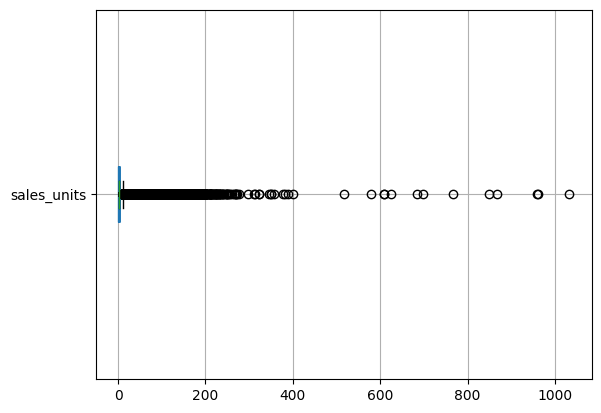

In [241]:
# общий боксплот
activ_store[['sales_units']].boxplot(vert=False, patch_artist=True, notch=True);

In [242]:
Q1 = activ_store.sales_units.quantile(0.25)
Q3 = activ_store.sales_units.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR

print('Верхняя граница:', upper)
print('Нижняя граница:', lower)

Верхняя граница: 11.0
Нижняя граница: -5.0


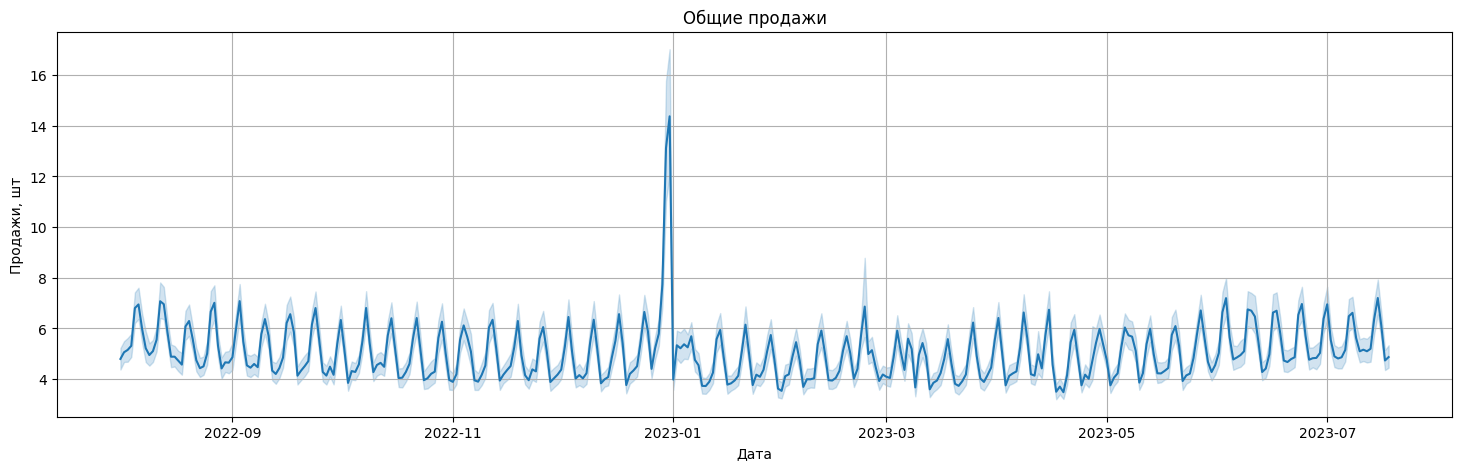

In [243]:
# общие продажи
plt.figure(figsize=(18, 5))

sns.lineplot(data=activ_store, x=activ_store.index, y="sales_units")

plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title("Общие продажи")
plt.grid(True)
plt.show()

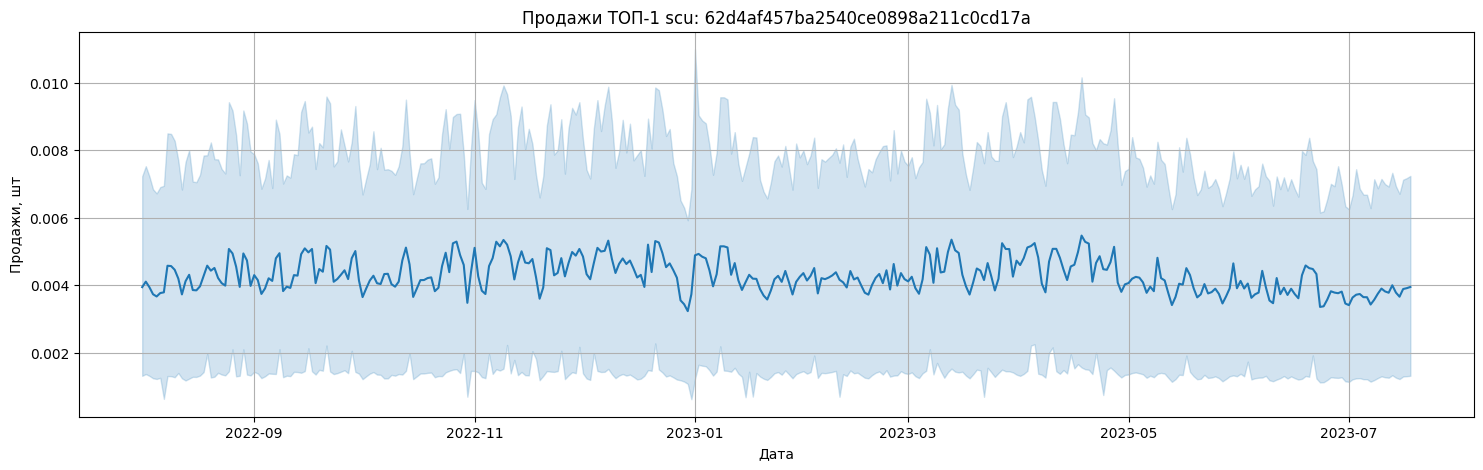

In [244]:
# самый популярный товор
plt.figure(figsize=(18, 5))

sns.lineplot(data=activ_store, x=activ_store.index, y=(activ_store['sku'] == '62d4af457ba2540ce0898a211c0cd17a'))

plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title("Продажи ТОП-1 scu: 62d4af457ba2540ce0898a211c0cd17a")
plt.grid(True)
plt.show()

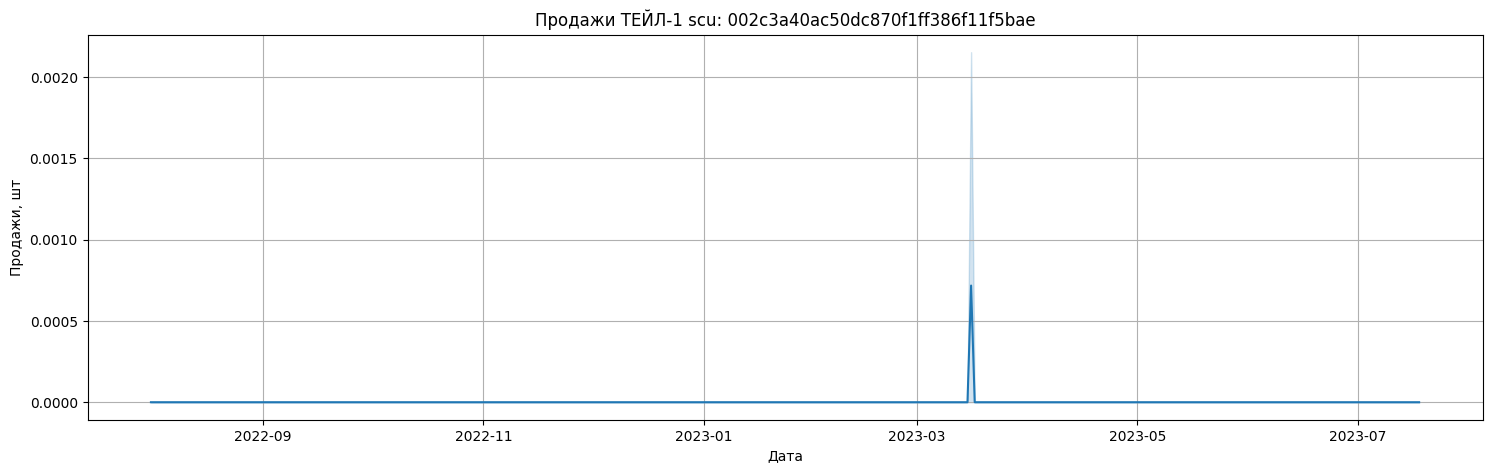

In [245]:
# самый не популярный товар
plt.figure(figsize=(18, 5))

sns.lineplot(data=activ_store, x=activ_store.index, y=(activ_store['sku'] == '002c3a40ac50dc870f1ff386f11f5bae'))

plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title("Продажи ТЕЙЛ-1 scu: 002c3a40ac50dc870f1ff386f11f5bae")
plt.grid(True)
plt.show()

### Добавляем признак цена за единицу товара - 'price_units'

In [246]:
# цена за единицу товара
activ_store['price_units'] = (activ_store['sales_rub'] / activ_store['sales_units']).round(2)

### Проведем нормализацию числовых признаков:
- sales_units,
- price_units,
- sales_rub
> Сформируем целевой признак 'sales_units_stand'

In [247]:
# нормализация продажи в штуках
sales_units_mean = activ_store.sales_units.mean()
sales_units_sd = activ_store.sales_units.std()

activ_store['sales_units_stand'] = (activ_store.sales_units - sales_units_mean) / sales_units_sd

In [248]:
# нормализация продажи в рублях
sales_rub_mean = activ_store.sales_rub.mean()
sales_rub_sd = activ_store.sales_rub.std()

activ_store['sales_rub_stand'] = (activ_store.sales_rub - sales_rub_mean) / sales_rub_sd

In [249]:
# нормализация доли промо продажи в рублях за штуку
price_units_mean = activ_store.price_units.mean()
price_units_sd = activ_store.price_units.std()

activ_store['price_units_stand'] = (activ_store.price_units - price_units_mean) / price_units_sd

In [250]:
activ_store.head()

,store,sku,sales_units,sales_rub,group,category,subcategory,uom,division,city,...,year,month,day,weekday,holiday,promo_part,price_units,sales_units_stand,sales_rub_stand,price_units_stand
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,21,462.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,2022,8,1,1,0,0.204,22.00,1.458935,-0.045953,-0.895639
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,6,860.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,2022,8,1,1,0,0.414,143.33,0.083276,0.338182,0.062514
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,3f33017a9ce4fbff701facaeae7a7549,1,65.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17,296bd0cc6e735f9d7488ebc8fbc19130,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,2022,8,1,1,0,0.211,65.00,-0.375277,-0.429122,-0.556065
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6d8bf88f6daf3b37de081afcf75ec6cf,17,1012.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,296bd0cc6e735f9d7488ebc8fbc19130,885fe656777008c335ac96072a45be15,...,2022,8,1,1,0,0.425,59.53,1.092093,0.484887,-0.599262
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,517b5edeb76505d48bb945abce481959,1,214.0,aab3238922bcc25a6f606eb525ffdc56,186a157b2992e7daed3677ce8e9fe40f,aa36dc1d45661519a5bf923429776a83,1,296bd0cc6e735f9d7488ebc8fbc19130,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,2022,8,1,1,0,0.335,214.00,-0.375277,-0.285313,0.620601


## Исследуем числовые и категориальные признаки

* Выделим числовые признаки и сохраним их в отдельную таблицу numeric
* Выделим категориальные признаки и сохраним их в отдельную таблицу categorical

In [251]:
numeric = activ_store[activ_store.select_dtypes(include='number').columns]
numeric.head(2)

,sales_units,sales_rub,uom,type_format,loc,size,year,month,day,weekday,holiday,promo_part,price_units,sales_units_stand,sales_rub_stand,price_units_stand
date,,,,,,,,,,,,,,,,
2022-08-01,21,462.0,17,1,1,8,2022,8,1,1,0,0.204,22.00,1.458935,-0.045953,-0.895639
2022-08-01,6,860.0,1,1,1,12,2022,8,1,1,0,0.414,143.33,0.083276,0.338182,0.062514
2022-08-01,1,65.0,17,1,2,8,2022,8,1,1,0,0.211,65.00,-0.375277,-0.429122,-0.556065
2022-08-01,17,1012.0,17,1,1,12,2022,8,1,1,0,0.425,59.53,1.092093,0.484887,-0.599262
2022-08-01,1,214.0,1,1,2,8,2022,8,1,1,0,0.335,214.00,-0.375277,-0.285313,0.620601


In [252]:
categorical = activ_store[activ_store.select_dtypes(include='object').columns]
categorical.head(2)

,store,sku,group,category,subcategory,division,city
date,,,,,,,
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f


In [253]:
categorical.columns.tolist()

['store', 'sku', 'group', 'category', 'subcategory', 'division', 'city']

In [254]:
categorical_columns = categorical.columns.tolist()

for column in categorical_columns:
    unique_count = activ_store[column].sort_values().nunique()
    print(f'Количество уникальных значений в столбце {column}',':', unique_count)

Количество уникальных значений в столбце store : 9
Количество уникальных значений в столбце sku : 1946
Количество уникальных значений в столбце group : 9
Количество уникальных значений в столбце category : 43
Количество уникальных значений в столбце subcategory : 167
Количество уникальных значений в столбце division : 5
Количество уникальных значений в столбце city : 6


In [255]:
numeric_columns = numeric.columns.tolist()

for column in numeric_columns:
    unique_count = activ_store[column].sort_values().nunique()
    print(f'Количество уникальных значений в столбце {column}',':', unique_count)

Количество уникальных значений в столбце sales_units : 261
Количество уникальных значений в столбце sales_rub : 8059
Количество уникальных значений в столбце uom : 2
Количество уникальных значений в столбце type_format : 3
Количество уникальных значений в столбце loc : 3
Количество уникальных значений в столбце size : 5
Количество уникальных значений в столбце year : 2
Количество уникальных значений в столбце month : 12
Количество уникальных значений в столбце day : 31
Количество уникальных значений в столбце weekday : 7
Количество уникальных значений в столбце holiday : 2
Количество уникальных значений в столбце promo_part : 702
Количество уникальных значений в столбце price_units : 23634
Количество уникальных значений в столбце sales_units_stand : 261
Количество уникальных значений в столбце sales_rub_stand : 8059
Количество уникальных значений в столбце price_units_stand : 23634


### Продажи по дням в шт и рублях

In [258]:
# список для построения графиков
sales_graph_list = [
    'sales_units',
    'price_units',
    'sales_rub'
]

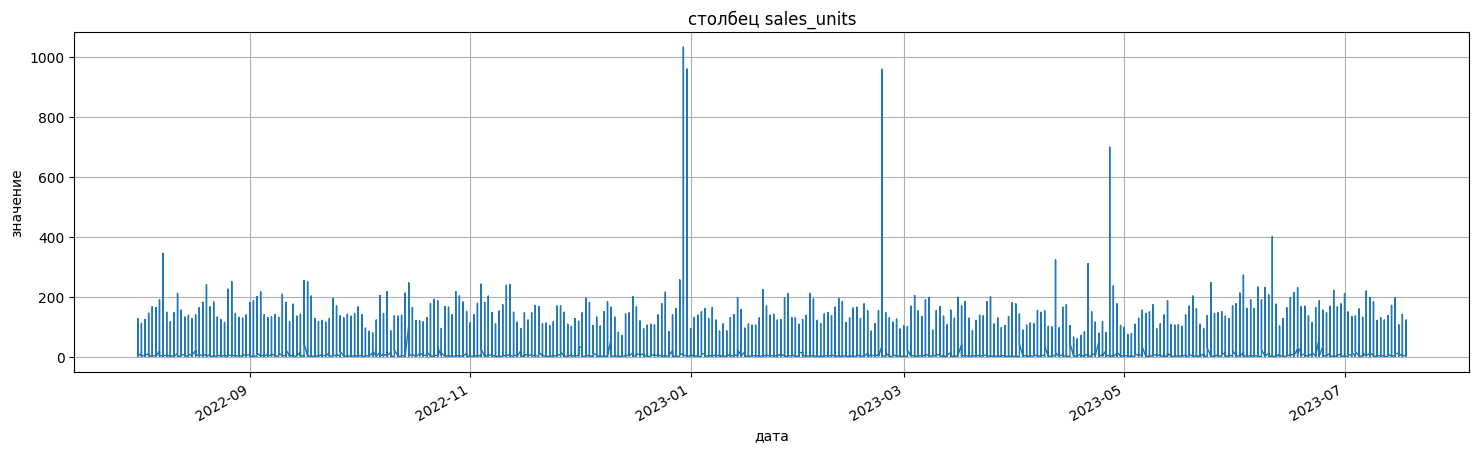

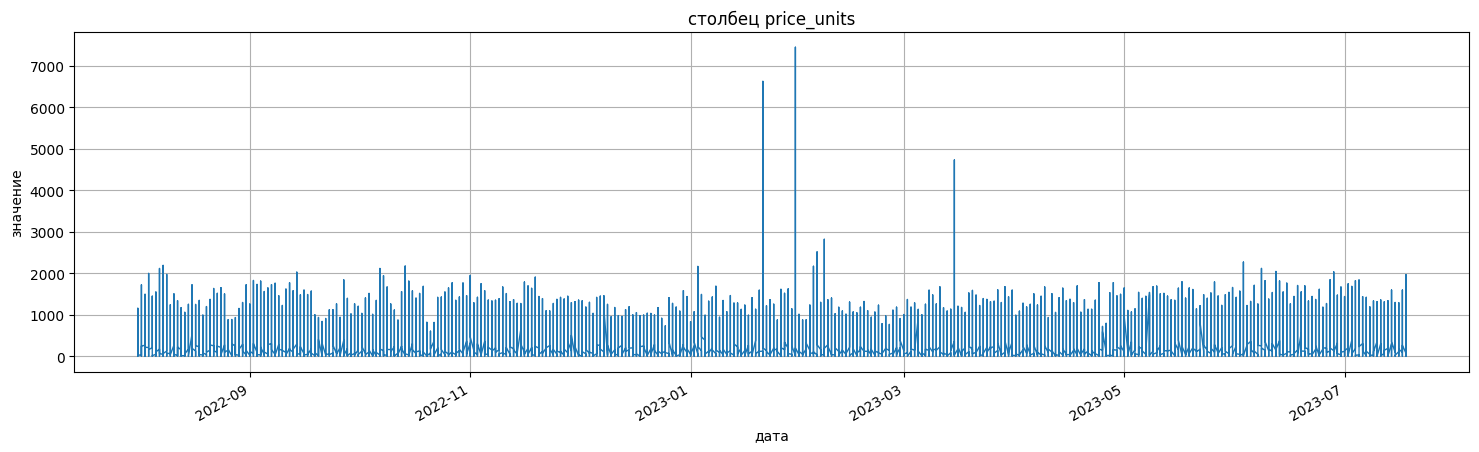

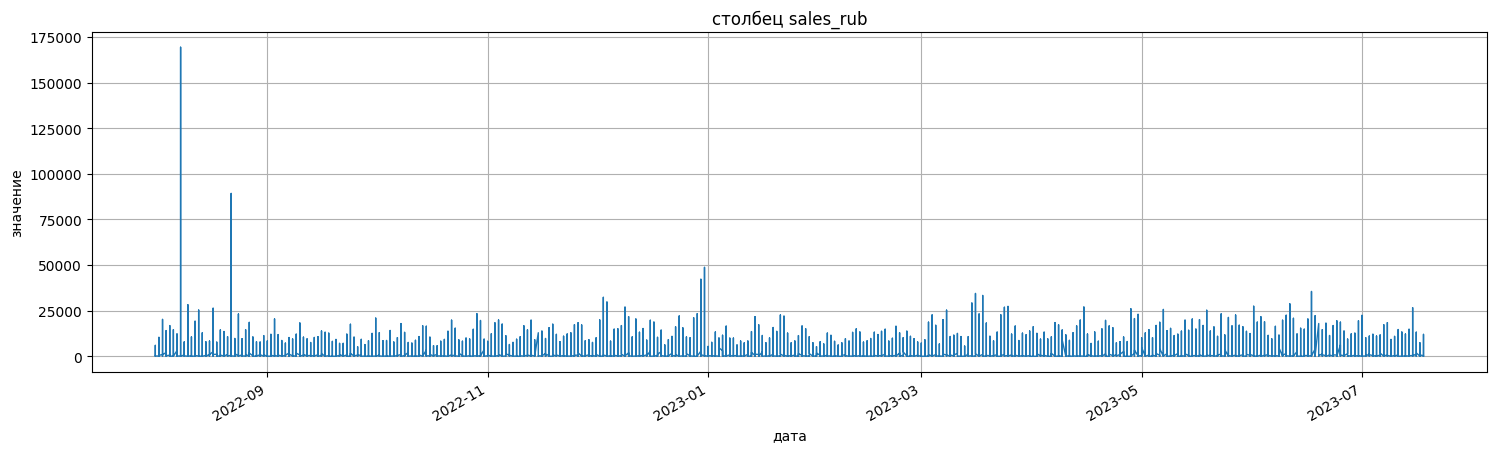

In [257]:
# цикл для построения графиков
for column in sales_graph_list:
    plt.figure(figsize=(18, 5))
    activ_store[column].plot(label=column, figsize=(18, 5), linewidth=1)
    #sns.lineplot(x=df.index, y=df[column])
    plt.title((f'столбец {column}'))
    plt.xlabel('дата')
    plt.ylabel('значение')
    plt.grid(True)
    plt.show()

In [259]:
activ_store[['price_units', 'sales_units', 'sales_rub']].describe().style.format("{:,.2f}")

,price_units,sales_units,sales_rub
count,"523,495.00","523,495.00","523,495.00"
mean,135.41,5.09,509.61
std,126.63,10.90,"1,036.09"
min,0.09,1.00,1.00
25%,45.00,1.00,115.00
50%,109.00,2.00,245.00
75%,189.50,5.00,531.00
max,"7,445.00","1,033.00","169,379.00"


### Построим корреляционную матрицу для смешанного набора признаков

In [260]:
numeric.columns

Index(['sales_units', 'sales_rub', 'uom', 'type_format', 'loc', 'size', 'year',
       'month', 'day', 'weekday', 'holiday', 'promo_part', 'price_units',
       'sales_units_stand', 'sales_rub_stand', 'price_units_stand'],
      dtype='object')

In [261]:
categorical.columns

Index(['store', 'sku', 'group', 'category', 'subcategory', 'division', 'city'], dtype='object')

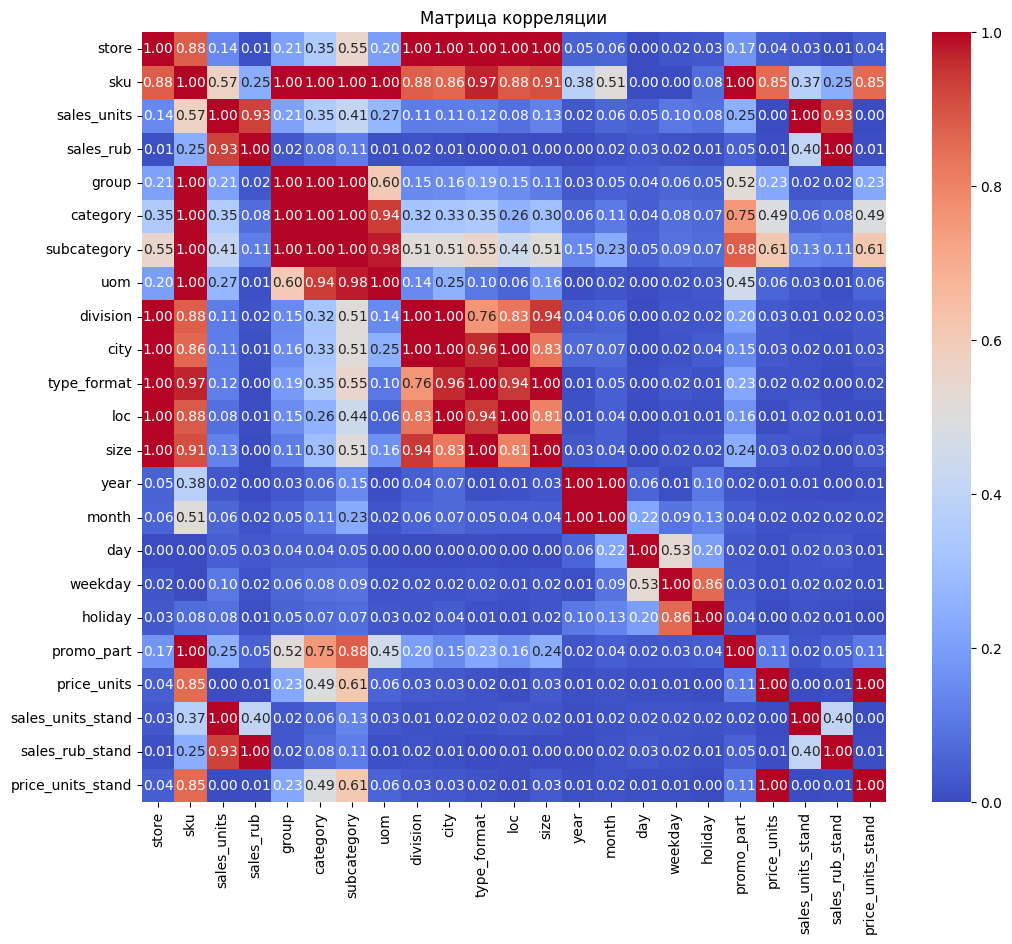

CPU times: user 17.5 s, sys: 1.77 s, total: 19.3 s
Wall time: 2min 1s


In [262]:
%%time
interval_cols = ['promo_part', 'price_units', 'sales_units_stand',
                 'sales_rub', 'sales_rub_stand', 'price_units_stand']
phik_matrix = activ_store.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

In [ ]:
#стоп

## Продажи товаров по категориям

### Группы товаров

In [263]:
# сделаем группировку и агрегацию по группам
grouped = activ_store.groupby('group')
pr_group_id = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
pr_group_id_sorted = pr_group_id.sort_values(by=('sales_rub', 'sum'), ascending=False)
pr_group_id_sorted

,sales_units,sales_rub
,sum,sum
group,,
aab3238922bcc25a6f606eb525ffdc56,784443,116420699.0
c74d97b01eae257e44aa9d5bade97baf,1429696,68732479.0
6512bd43d9caa6e02c990b0a82652dca,251265,42369796.0
c51ce410c124a10e0db5e4b97fc2af39,67576,20630412.0
c20ad4d76fe97759aa27a0c99bff6710,114730,14681318.0
32bb90e8976aab5298d5da10fe66f21d,7900,2084682.0
1ff1de774005f8da13f42943881c655f,9549,1808134.0
98f13708210194c475687be6106a3b84,432,49854.0


### Категории товаров

In [264]:
# сделаем группировку и агрегацию по подкатегориям
grouped = activ_store.groupby('category')
pr_cat_id = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
pr_cat_id_sorted = pr_cat_id.sort_values(by=('sales_rub', 'sum'), ascending=False)
pr_cat_id_sorted.head()

,sales_units,sales_rub
,sum,sum
category,,
28fc2782ea7ef51c1104ccf7b9bea13d,264803,47632120.0
c559da2ba967eb820766939a658022c8,896770,34467161.0
9701a1c165dd9420816bfec5edd6c2b1,199439,29745727.0
e58cc5ca94270acaceed13bc82dfedf7,146346,22770289.0
186a157b2992e7daed3677ce8e9fe40f,152587,21213278.0


### Подкатегории товаров

In [265]:
# сделаем группировку и агрегацию по подкатегориям
grouped = activ_store.groupby('subcategory')
pr_subcat_id = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
pr_subcat_id_sorted = pr_subcat_id.sort_values(by=('sales_rub', 'sum'), ascending=False)
pr_subcat_id_sorted.head()

,sales_units,sales_rub
,sum,sum
subcategory,,
aa36dc1d45661519a5bf923429776a83,145260,20155924.0
c93c26cd49ea08e6b8984351d4164575,82805,16039692.0
7a8aebb07d6e8ba9da453ec0f3f359a4,54720,12285820.0
d29b5ce9c2883f0b7e90f79071a2ca82,58444,11153125.0
e06f5ed77191826c212c30722f2cc5a2,327731,10998687.0


### Добавим доли продаж товаров по категориям в шт и руб

In [287]:
#напишем функцию по формированию признаков долей
def sales_share(data, name_col, name, columns_to_process):
    for column in columns_to_process:
        unique_counts = data.groupby(column)['sku'].nunique()# количество уникальных товаров в каждой категории/типа магазина
        sales_sum = data.groupby(column)[name_col].sum() # сумма продаж для каждой категории/типа магазина
        sku_sales = unique_counts / sales_sum # доля продаж уникальных товаров в каждой категории/типа магазина
        # доля продаж уникальных товаров в таблицу
        data[f'sales_share_{column}_{name}'] = data[column].map(sku_sales)
    return data

In [267]:
# перебор по категориям
columns_to_process = ['group', 'category', 'subcategory']
#Добавим доли продаж товаров по категориям в шт
activ_store = sales_share(activ_store, 'sales_units', 'unit', columns_to_process)
#Добавим доли продаж товаров по категориям в rub
activ_store = sales_share(activ_store, 'sales_rub', 'rub', columns_to_process)
activ_store.head(3)

,store,sku,sales_units,sales_rub,group,category,subcategory,uom,division,city,...,price_units,sales_units_stand,sales_rub_stand,price_units_stand,sales_share_group_unit,sales_share_category_unit,sales_share_subcategory_unit,sales_share_group_rub,sales_share_category_rub,sales_share_subcategory_rub
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,21,462.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,22.00,1.458935,-0.045953,-0.895639,0.000516,0.000270,0.000101,0.000011,0.000007,3.000358e-06
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,6,860.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,143.33,0.083276,0.338182,0.062514,0.000885,0.001078,0.001175,0.000006,0.000007,1.041206e-05
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,3f33017a9ce4fbff701facaeae7a7549,1,65.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17,296bd0cc6e735f9d7488ebc8fbc19130,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,65.00,-0.375277,-0.429122,-0.556065,0.000516,0.000665,0.000724,0.000011,0.000016,1.908562e-05
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6d8bf88f6daf3b37de081afcf75ec6cf,17,1012.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,296bd0cc6e735f9d7488ebc8fbc19130,885fe656777008c335ac96072a45be15,...,59.53,1.092093,0.484887,-0.599262,0.000516,0.000270,0.000101,0.000011,0.000007,3.000358e-06
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,517b5edeb76505d48bb945abce481959,1,214.0,aab3238922bcc25a6f606eb525ffdc56,186a157b2992e7daed3677ce8e9fe40f,aa36dc1d45661519a5bf923429776a83,1,296bd0cc6e735f9d7488ebc8fbc19130,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,214.00,-0.375277,-0.285313,0.620601,0.000885,0.000157,0.000110,0.000006,0.000001,7.938113e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-18,42a0e188f5033bc65bf8d78622277c4e,1d2448c22721c94bb0264cf52598522f,49,440.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,1507fc0175c1ff0cf4440105bc6f93e6,17,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,8.98,4.026832,-0.067186,-0.998459,0.000516,0.000665,0.000098,0.000011,0.000016,5.025230e-06
2023-07-18,16a5cdae362b8d27a1d8f8c7b78b4330,10d26ea8eac593b8e397fc0aad2134c4,2,46.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,6639ae8d530e71980239f7bff60e247c,17,296bd0cc6e735f9d7488ebc8fbc19130,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,23.00,-0.283566,-0.447460,-0.887742,0.000516,0.000665,0.000793,0.000011,0.000016,1.864698e-05
2023-07-18,42a0e188f5033bc65bf8d78622277c4e,a7a9eb3ffb9634e37c50995c34da34d0,2,83.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,2a307e6985c82c6245bc0b3186cdf9bc,17,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,41.50,-0.283566,-0.411749,-0.741646,0.000516,0.000665,0.000609,0.000011,0.000016,1.306790e-05


In [268]:
# оценим доли продаж scu в группах товаров и сортируем в порядке убывания долей
activ_store.groupby('group')[['sku', 'sales_share_group_unit']].apply(lambda x: x.sort_values(ascending=False, by='sales_share_group_unit'))

sku  \
group                            date                                           
1ff1de774005f8da13f42943881c655f 2022-08-01  a97a38f8bcdf16c8d11f2010bb409da5   
                                 2023-03-13  70f6f2543cdaf69fb2f89317e23a0929   
                                 2023-03-12  70f6f2543cdaf69fb2f89317e23a0929   
                                 2023-03-12  45bd6ffd65dc1b68ea59c9ec5f4590f9   
                                 2023-03-12  09b6f670e4f5648aef001e34f7945990   
...                                                                       ...   
c74d97b01eae257e44aa9d5bade97baf 2022-11-25  d5bfeecaaa47887a4b92d17fa55c2e18   
                                 2022-11-25  cff633e270708ced01bc585eb1421667   
                                 2022-11-25  1edb148e94ceddc5abaa91ad4814a737   
                                 2022-11-25  22988026fe85fde60d8bf777ab6bc3b4   
                                 2023-07-18  083e7f594409e946662187b13b13868a   

                                             sales_share_group_unit  
group                            date                                
1ff1de774005f8da13f42943881c655f 2022-08-01                0.003665  
                                 2023-03-13                0.003665  
                                 2023-03-12                0.003665  
                                 2023-03-12                0.003665  
                                 2023-03-12                0.003665  
...                                                             ...  
c74d97b01eae257e44aa9d5bade97baf 2022-11-25                0.000516  
                                 2022-11-25                0.000516  
                                 2022-11-25                0.000516  
                                 2022-11-25                0.000516  
                                 2023-07-18                0.000516  

[523495 rows x 2 columns]

In [269]:
# оценим доли продаж scu в группах товаров и сортируем в порядке убывания долей
activ_store.groupby('group')[['sku', 'sales_share_group_rub']].apply(lambda x: x.sort_values(ascending=False, by='sales_share_group_rub'))

sku  \
group                            date                                           
1ff1de774005f8da13f42943881c655f 2022-08-01  a97a38f8bcdf16c8d11f2010bb409da5   
                                 2023-03-13  70f6f2543cdaf69fb2f89317e23a0929   
                                 2023-03-12  70f6f2543cdaf69fb2f89317e23a0929   
                                 2023-03-12  45bd6ffd65dc1b68ea59c9ec5f4590f9   
                                 2023-03-12  09b6f670e4f5648aef001e34f7945990   
...                                                                       ...   
c74d97b01eae257e44aa9d5bade97baf 2022-11-25  d5bfeecaaa47887a4b92d17fa55c2e18   
                                 2022-11-25  cff633e270708ced01bc585eb1421667   
                                 2022-11-25  1edb148e94ceddc5abaa91ad4814a737   
                                 2022-11-25  22988026fe85fde60d8bf777ab6bc3b4   
                                 2023-07-18  083e7f594409e946662187b13b13868a   

                                             sales_share_group_rub  
group                            date                               
1ff1de774005f8da13f42943881c655f 2022-08-01               0.000019  
                                 2023-03-13               0.000019  
                                 2023-03-12               0.000019  
                                 2023-03-12               0.000019  
                                 2023-03-12               0.000019  
...                                                            ...  
c74d97b01eae257e44aa9d5bade97baf 2022-11-25               0.000011  
                                 2022-11-25               0.000011  
                                 2022-11-25               0.000011  
                                 2022-11-25               0.000011  
                                 2023-07-18               0.000011  

[523495 rows x 2 columns]

In [270]:
# группы товара
activ_store.pivot_table(index=['group'],
               values=['sales_rub'],
               aggfunc=[np.mean, len, sum]
              ).sort_values(by=('sum', 'sales_rub'), ascending=False)

,mean,len,sum
,sales_rub,sales_rub,sales_rub
group,,,
aab3238922bcc25a6f606eb525ffdc56,602.457522,193243,116420699.0
c74d97b01eae257e44aa9d5bade97baf,284.318100,241745,68732479.0
6512bd43d9caa6e02c990b0a82652dca,990.457618,42778,42369796.0
c51ce410c124a10e0db5e4b97fc2af39,943.881228,21857,20630412.0
c20ad4d76fe97759aa27a0c99bff6710,868.768448,16899,14681318.0
32bb90e8976aab5298d5da10fe66f21d,750.966138,2776,2084682.0
1ff1de774005f8da13f42943881c655f,450.008462,4018,1808134.0
98f13708210194c475687be6106a3b84,294.994083,169,49854.0


### В штуках всего

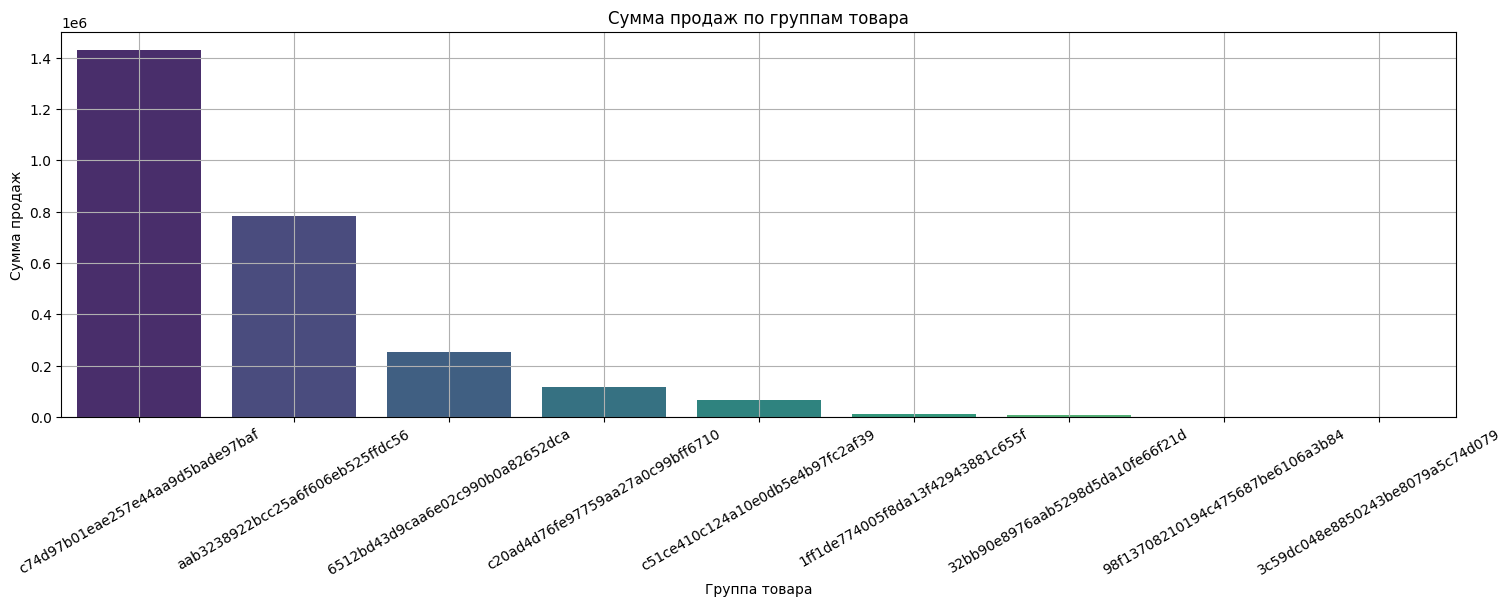

In [271]:
# группы
pivot_table = activ_store.pivot_table(index=['group'],
                                      values=['sales_units'],
                                      aggfunc=[np.mean, len, sum]
                                      ).sort_values(by=('sum', 'sales_units'), ascending=False)
plt.figure(figsize=(18, 5))
sns.barplot(x=pivot_table.index, y=('sum', 'sales_units'), data=pivot_table, palette="viridis")

plt.title('Сумма продаж по группам товара')
plt.xlabel('Группа товара')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=30)
plt.grid(True)

plt.show()

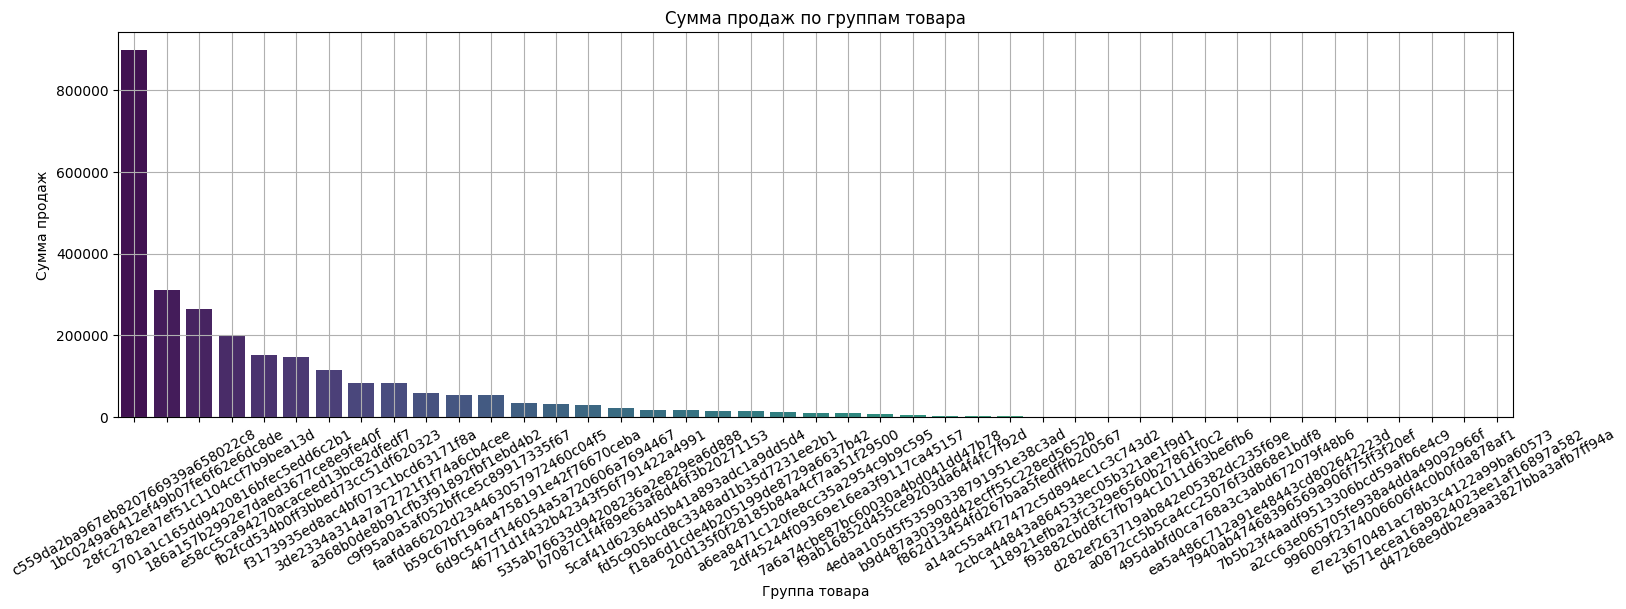

In [273]:
# категории
pivot_table = activ_store.pivot_table(index=['category'],
                                      values=['sales_units'],
                                      aggfunc=[np.mean, len, sum]
                                      ).sort_values(by=('sum', 'sales_units'), ascending=False)
plt.figure(figsize=(18, 5))
sns.barplot(x=pivot_table.index, y=('sum', 'sales_units'), data=pivot_table, palette="viridis")

plt.title('Сумма продаж по группам товара')
plt.xlabel('Группа товара')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=30)
plt.grid(True)

plt.show()

In [274]:
# подкатегории
activ_store.pivot_table(index=['subcategory'],
               values=['sales_rub'],
               aggfunc=[np.mean, len, sum]
              ).sort_values(by=('len', 'sales_rub'), ascending=False).round()

,mean,len,sum
,sales_rub,sales_rub,sales_rub
subcategory,,,
e06f5ed77191826c212c30722f2cc5a2,490.0,22428,10998687.0
c01c475ac8d447730ece97d846cc4f25,339.0,16697,5666504.0
ca34f669ae367c87f0e75dcae0f61ee5,140.0,16074,2253005.0
8afe22eeb3f3f68de994a3c60388858c,463.0,15637,7238078.0
7a8aebb07d6e8ba9da453ec0f3f359a4,807.0,15230,12285820.0
...,...,...,...
16d222a5fac9d8d7a3ee790f9ee46af5,130.0,2,259.0
c6e0511febe73b0911198c2b79d27ec0,210.0,2,420.0


In [275]:
activ_store.pivot_table(index=['sku'],
               values=['sales_rub'],
               aggfunc=[np.mean, len, sum]
              ).sort_values(by=('len', 'sales_rub'), ascending=False).sort_values(by=('sum', 'sales_rub'), ascending=False).round()

,mean,len,sum
,sales_rub,sales_rub,sales_rub
sku,,,
c0e3f3bd815a862433bc3399c487926b,7560.0,1639,12390585.0
c7b711619071c92bef604c7ad68380dd,2609.0,1843,4807865.0
67797f1f0f02ec5ccd5e3abd2d4e5b81,2603.0,1691,4401548.0
ced0c1a84924c982a6403870c54b99ca,1318.0,2061,2716498.0
4695acecbef4734453cf9bc0be67ffe4,3830.0,684,2620036.0
...,...,...,...
ac3a9c95767b01bdb4bdfdbec835b24b,33.0,1,33.0
9859c09401e6a000fb502c507afa866c,30.0,1,30.0


## Продажи по типам магазинов

In [276]:
type_graph_list = [
    'type_format',
    'loc',
    'size',
    'uom'
]

type_format    type_format
1     0.939216
2     0.051097
4     0.009687


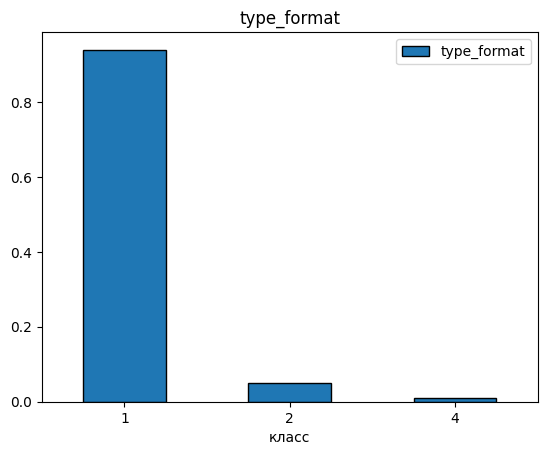

loc         loc
1  0.803798
2  0.186516
3  0.009687


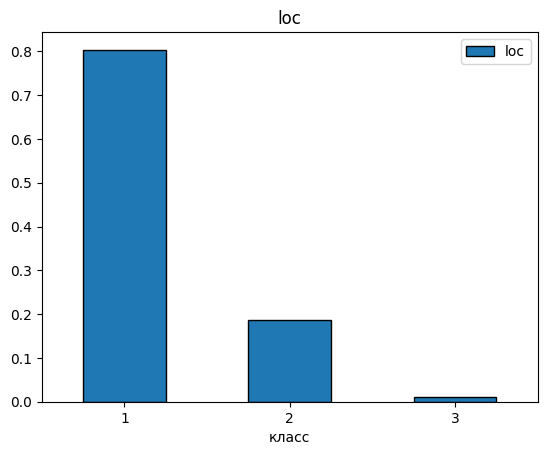

size         size
12  0.565579
8   0.373637
28  0.051097
20  0.007958
19  0.001729


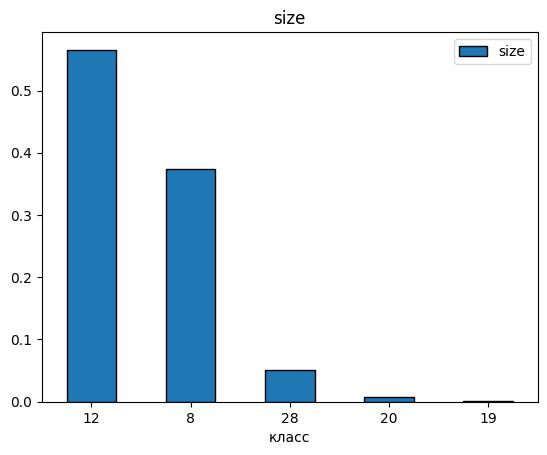

uom          uom
1   0.619303
17  0.380697


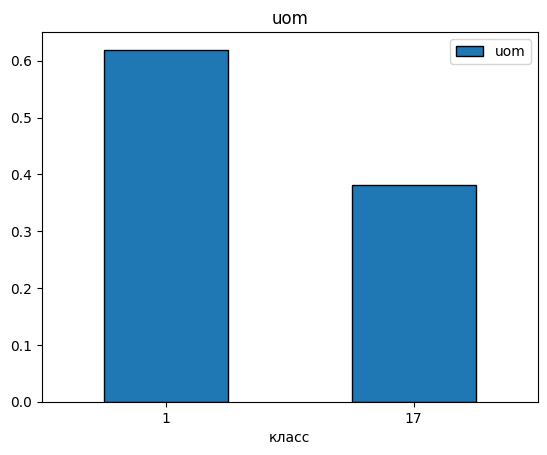

In [277]:
for column in type_graph_list:
    class_frequency = activ_store[column].value_counts(normalize= True).to_frame()
    print(f'{column}',class_frequency)
    ax = class_frequency.plot(kind='bar', rot=0, edgecolor='black', linewidth=1)
    ax.set_xlabel('класс')
    ax.set_title(f'{column}')
    plt.show()

In [278]:
# маркер товаров продающихся по штучно = 1, на вес = 0
activ_store['uom'] = activ_store['uom'].apply(lambda x: 0 if x != 1 else x)

### Продажи по локациям

In [279]:
# сделаем группировку и агрегацию по локациям магазинов
grouped = activ_store.groupby('loc')
st_type_loc = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
st_type_loc_sorted = st_type_loc.sort_values(by=('sales_units', 'sum'), ascending=False)
st_type_loc_sorted

,sales_units,sales_rub
,sum,sum
loc,,
1,2103264,211728824.0
2,551323,54449786.0
3,11032,600371.0


### Продажи по размерам

In [280]:
# сделаем группировку и агрегацию по размерам магазинов
grouped = activ_store.groupby('size')
st_type_size = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
st_type_size_sorted = st_type_size.sort_values(by=('sales_units', 'sum'), ascending=False)
st_type_size_sorted

,sales_units,sales_rub
,sum,sum
size,,
12,1452064,148260566.0
8,1121617,112459747.0
28,80906,5458297.0
20,9298,520370.0
19,1734,80001.0


### Продажи по форматам

In [281]:
# сделаем группировку и агрегацию по локациям магазинов
grouped = activ_store.groupby('type_format')
st_type_format = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
st_type_format_sorted = st_type_format.sort_values(by=('sales_units', 'sum'), ascending=False)
st_type_format_sorted

,sales_units,sales_rub
,sum,sum
type_format,,
1,2573681,260720313.0
2,80906,5458297.0
4,11032,600371.0


### Добавим доли продаж в штуках и в рублях для каждого sku

In [288]:
# перебор по магазинам
columns_to_process_sku = ['store', 'sku','year', 'weekday', 'month',
                              'division', 'city', 'type_format', 'loc','size']
#Добавим доли продаж товаров по магазинам в шт
activ_store = sales_share(activ_store, 'sales_units', 'sku_unit', columns_to_process_sku)
#Добавим доли продаж товаров по магазинам в rub
activ_store = sales_share(activ_store, 'sales_rub', 'sku_rub', columns_to_process_sku)

In [289]:
activ_store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523495 entries, 2022-08-01 to 2023-07-18
Data columns (total 49 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   store                             523495 non-null  object 
 1   sku                               523495 non-null  object 
 2   sales_units                       523495 non-null  int64  
 3   sales_rub                         523495 non-null  float64
 4   group                             523495 non-null  object 
 5   category                          523495 non-null  object 
 6   subcategory                       523495 non-null  object 
 7   uom                               523495 non-null  int64  
 8   division                          523495 non-null  object 
 9   city                              523495 non-null  object 
 10  type_format                       523495 non-null  int64  
 11  loc                               52

In [290]:
activ_store.tail()

,store,sku,sales_units,sales_rub,group,category,subcategory,uom,division,city,...,sales_share_store_sku_rub,sales_share_sku_sku_rub,sales_share_year_sku_rub,sales_share_weekday_sku_rub,sales_share_month_sku_rub,sales_share_division_sku_rub,sales_share_city_sku_rub,sales_share_type_format_sku_rub,sales_share_loc_sku_rub,sales_share_size_sku_rub
date,,,,,,,,,,,,,,,,,,,,,
2023-07-18,42a0e188f5033bc65bf8d78622277c4e,1d2448c22721c94bb0264cf52598522f,49,440.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,1507fc0175c1ff0cf4440105bc6f93e6,0,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,0.000024,2.219175e-06,0.000011,0.000054,0.000065,0.000015,0.000015,0.000007,0.000009,0.000009
2023-07-18,16a5cdae362b8d27a1d8f8c7b78b4330,10d26ea8eac593b8e397fc0aad2134c4,2,46.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,6639ae8d530e71980239f7bff60e247c,0,296bd0cc6e735f9d7488ebc8fbc19130,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,0.000017,1.284637e-05,0.000011,0.000054,0.000065,0.000011,0.000017,0.000007,0.000017,0.000012
2023-07-18,42a0e188f5033bc65bf8d78622277c4e,a7a9eb3ffb9634e37c50995c34da34d0,2,83.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,2a307e6985c82c6245bc0b3186cdf9bc,0,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,0.000024,5.887548e-06,0.000011,0.000054,0.000065,0.000015,0.000015,0.000007,0.000009,0.000009
2023-07-18,c81e728d9d4c2f636f067f89cc14862c,ced0c1a84924c982a6403870c54b99ca,11,401.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,0.000018,3.681210e-07,0.000011,0.000054,0.000065,0.000019,0.000019,0.000007,0.000009,0.000012
2023-07-18,6364d3f0f495b6ab9dcf8d3b5c6e0b01,083e7f594409e946662187b13b13868a,1,29.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,329ccb6e98ddf18590822febd4ccb380,0,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,0.000028,1.969667e-04,0.000011,0.000054,0.000065,0.000015,0.000015,0.000007,0.000009,0.000009


In [ ]:
# activ_store = activ_store.drop(['pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'st_division_code', 'st_city_id'], axis=1)

In [ ]:
#СТОП СТОП СТОП

# Продажи

## Магазины

In [ ]:
# продажи в шт по магазинам
activ_store.groupby('st_id').pr_sales_in_units.agg(['sum']).sort_values(by=('sum'), ascending=False)

,sum
st_id,
c81e728d9d4c2f636f067f89cc14862c,570373
16a5cdae362b8d27a1d8f8c7b78b4330,551339
f7e6c85504ce6e82442c770f7c8606f0,419168
42a0e188f5033bc65bf8d78622277c4e,407403
fa7cdfad1a5aaf8370ebeda47a1ff1c3,330681
6364d3f0f495b6ab9dcf8d3b5c6e0b01,295306
1ecfb463472ec9115b10c292ef8bc986,80963
53e19f3dbb211f20b20b45668303c1b6,9379
bd470ca955d9497bbcb808e59952fffc,1768


In [ ]:
# scu и магазин с самими высокими продажами в шт
sku_st = activ_store[(activ_store['st_id'] == 'c81e728d9d4c2f636f067f89cc14862c') & (activ_store['pr_sku_id'] == '62d4af457ba2540ce0898a211c0cd17a')]
sku_st.reset_index()

,date,st_id,pr_sku_id,pr_sales_in_units,pr_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_division_code,...,sku_sales_share_st_idin_rub,sku_sales_share_pr_sku_idin_rub,sku_sales_share_yearin_rub,sku_sales_share_weekdayin_rub,sku_sales_share_monthin_rub,sku_sales_share_st_division_codein_rub,sku_sales_share_st_city_idin_rub,sku_sales_share_st_type_format_idin_rub,sku_sales_share_st_type_loc_idin_rub,sku_sales_share_st_type_size_idin_rub
0,2022-08-01,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,89,1294.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,...,0.000018,5.923381e-07,0.000014,0.000055,0.000048,0.000019,0.000019,0.000007,0.000009,0.000012
1,2022-08-02,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,77,1118.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,...,0.000018,5.923381e-07,0.000014,0.000055,0.000048,0.000019,0.000019,0.000007,0.000009,0.000012
2,2022-08-03,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,70,1022.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,...,0.000018,5.923381e-07,0.000014,0.000053,0.000048,0.000019,0.000019,0.000007,0.000009,0.000012
3,2022-08-04,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,71,1031.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,...,0.000018,5.923381e-07,0.000014,0.000054,0.000048,0.000019,0.000019,0.000007,0.000009,0.000012
4,2022-08-05,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,86,1255.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,...,0.000018,5.923381e-07,0.000014,0.000038,0.000048,0.000019,0.000019,0.000007,0.000009,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2023-07-14,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,54,925.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,...,0.000018,5.923381e-07,0.000011,0.000038,0.000065,0.000019,0.000019,0.000007,0.000009,0.000012
346,2023-07-15,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,43,745.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,...,0.000018,5.923381e-07,0.000011,0.000032,0.000065,0.000019,0.000019,0.000007,0.000009,0.000012
347,2023-07-16,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,57,979.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,...,0.000018,5.923381e-07,0.000011,0.000044,0.000065,0.000019,0.000019,0.000007,0.000009,0.000012
348,2023-07-17,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,28,482.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,...,0.000018,5.923381e-07,0.000011,0.000055,0.000065,0.000019,0.000019,0.000007,0.000009,0.000012


In [ ]:
unique_count = activ_store['pr_sku_id'].nunique()
print(f"Количество уникальных значений в столбце 'pr_sku_id': {unique_count}")

Количество уникальных значений в столбце 'pr_sku_id': 1986


In [ ]:
top_st_list = activ_store['st_id'].unique().tolist()
top_st_list

['c81e728d9d4c2f636f067f89cc14862c',
 '42a0e188f5033bc65bf8d78622277c4e',
 '16a5cdae362b8d27a1d8f8c7b78b4330',
 'fa7cdfad1a5aaf8370ebeda47a1ff1c3',
 'f7e6c85504ce6e82442c770f7c8606f0',
 '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
 '1ecfb463472ec9115b10c292ef8bc986',
 'bd470ca955d9497bbcb808e59952fffc',
 '53e19f3dbb211f20b20b45668303c1b6']

In [ ]:
# словарь для уникальных pr_sku_id для каждого магазина
unique_sku_counts = {}

for st in top_st_list:
    filtered_st = activ_store[activ_store['st_id'] == st]
    unique_count = filtered_st['pr_sku_id'].nunique()
    unique_sku_counts[st] = unique_count

# сртируем словарь по убыванию
sorted_unique_sku_counts = dict(sorted(unique_sku_counts.items(), key=lambda item: item[1], reverse=True))

for st, unique_count in sorted_unique_sku_counts.items():
    print(f"Количество уникальных pr_sku_id для st_id = {st}: {unique_count}")


Количество уникальных pr_sku_id для st_id = c81e728d9d4c2f636f067f89cc14862c: 1055
Количество уникальных pr_sku_id для st_id = 42a0e188f5033bc65bf8d78622277c4e: 1007
Количество уникальных pr_sku_id для st_id = 16a5cdae362b8d27a1d8f8c7b78b4330: 937
Количество уникальных pr_sku_id для st_id = f7e6c85504ce6e82442c770f7c8606f0: 929
Количество уникальных pr_sku_id для st_id = 6364d3f0f495b6ab9dcf8d3b5c6e0b01: 861
Количество уникальных pr_sku_id для st_id = fa7cdfad1a5aaf8370ebeda47a1ff1c3: 793
Количество уникальных pr_sku_id для st_id = 1ecfb463472ec9115b10c292ef8bc986: 250
Количество уникальных pr_sku_id для st_id = 53e19f3dbb211f20b20b45668303c1b6: 110
Количество уникальных pr_sku_id для st_id = bd470ca955d9497bbcb808e59952fffc: 72


In [ ]:
list_cat = activ_store['pr_cat_id'].unique().tolist()

In [ ]:
# словарь для уникальных pr_sku_id для каждой категории
unique_sku_counts = {}

for cat in list_cat:
    filtered_cat = activ_store[activ_store['pr_cat_id'] == cat]
    unique_count = filtered_cat['pr_sku_id'].nunique()
    unique_sku_counts[cat] = unique_count

# сортируем словарь по убыванию
sorted_unique_sku_counts = dict(sorted(unique_sku_counts.items(), key=lambda item: item[1], reverse=True))

for cat, unique_count in sorted_unique_sku_counts.items():
    print(f"Количество уникальных pr_sku_id для pr_cat_id = {cat}: {unique_count}")

Количество уникальных pr_sku_id для pr_cat_id = c559da2ba967eb820766939a658022c8: 243
Количество уникальных pr_sku_id для pr_cat_id = 9701a1c165dd9420816bfec5edd6c2b1: 217
Количество уникальных pr_sku_id для pr_cat_id = 1bc0249a6412ef49b07fe6f62e6dc8de: 211
Количество уникальных pr_sku_id для pr_cat_id = 28fc2782ea7ef51c1104ccf7b9bea13d: 165
Количество уникальных pr_sku_id для pr_cat_id = 46771d1f432b42343f56f791422a4991: 111
Количество уникальных pr_sku_id для pr_cat_id = f3173935ed8ac4bf073c1bcd63171f8a: 104
Количество уникальных pr_sku_id для pr_cat_id = e58cc5ca94270acaceed13bc82dfedf7: 95
Количество уникальных pr_sku_id для pr_cat_id = a368b0de8b91cfb3f91892fbf1ebd4b2: 83
Количество уникальных pr_sku_id для pr_cat_id = 3de2334a314a7a72721f1f74a6cb4cee: 78
Количество уникальных pr_sku_id для pr_cat_id = fb2fcd534b0ff3bbed73cc51df620323: 71
Количество уникальных pr_sku_id для pr_cat_id = 535ab76633d94208236a2e829ea6d888: 61
Количество уникальных pr_sku_id для pr_cat_id = b7087c1f4f8

## Группировка дата - магазин - scu - количество

In [291]:
# пропуски в процентах
def lost(data):
    if data.isna().sum().sum()>0:
        display(
            (round(data.isna().mean()*100,3))
            .to_frame()
            .rename(columns = {0:'Пропуски'})
            .query('Пропуски > 0')
            .sort_values(by = 'Пропуски', ascending = False)
            .style.background_gradient('coolwarm')
        )
    else:
        print('Пропусков нет')

In [292]:
lost(activ_store)

Пропусков нет


In [293]:
# группировка продаж по датам и магазинам
groop_day_activ_store = activ_store.groupby([pd.Grouper(freq='D'), 'store', 'sku'])['sales_units'].sum().reset_index()
groop_day_activ_store

,date,store,sku,sales_units
0,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,1
1,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,4
2,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,033013f94a18c066e8b3d610bed34bee,4
3,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,04bbb07b1057b09d04209991f3eadd8f,1
4,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,0570ab7d07a4f2587f1ad4c4ed77e333,14
...,...,...,...,...
523490,2023-07-18,fa7cdfad1a5aaf8370ebeda47a1ff1c3,f5a455e5fea834c85429331d934c40fa,2
523491,2023-07-18,fa7cdfad1a5aaf8370ebeda47a1ff1c3,f66b339c9fe074ffe2731d83f4a97821,5
523492,2023-07-18,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fbf6c91454d7c3cea7b03f3092cbfb73,1
523493,2023-07-18,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fdb89dfd1a27256904eb5a5734252102,4


In [295]:
activ_store.columns

Index(['store', 'sku', 'sales_units', 'sales_rub', 'group', 'category',
       'subcategory', 'uom', 'division', 'city', 'type_format', 'loc', 'size',
       'year', 'month', 'day', 'weekday', 'holiday', 'promo_part',
       'price_units', 'sales_units_stand', 'sales_rub_stand',
       'price_units_stand', 'sales_share_group_unit',
       'sales_share_category_unit', 'sales_share_subcategory_unit',
       'sales_share_group_rub', 'sales_share_category_rub',
       'sales_share_subcategory_rub', 'sales_share_store_sku_unit',
       'sales_share_sku_sku_unit', 'sales_share_year_sku_unit',
       'sales_share_weekday_sku_unit', 'sales_share_month_sku_unit',
       'sales_share_division_sku_unit', 'sales_share_city_sku_unit',
       'sales_share_type_format_sku_unit', 'sales_share_loc_sku_unit',
       'sales_share_size_sku_unit', 'sales_share_store_sku_rub',
       'sales_share_sku_sku_rub', 'sales_share_year_sku_rub',
       'sales_share_weekday_sku_rub', 'sales_share_month_sku_rub',
   

In [297]:
# полная группировка продаж по магазинам
full_group = activ_store.groupby([pd.Grouper(freq='D'), 'store', 'sku', 'uom', 'year', 'month',
       'day', 'weekday', 'holiday', 'promo_part', 'price_units',
       'sales_units_stand', 'price_units_stand',
       'sales_share_group_unit','sales_share_category_unit', 'sales_share_subcategory_unit',
       'sales_share_division_sku_unit', 'sales_share_city_sku_unit',
       'sales_share_type_format_sku_unit', 'sales_share_loc_sku_unit',
       'sales_share_size_sku_unit'])['sales_units'].sum().reset_index()
full_group

,date,store,sku,uom,year,month,day,weekday,holiday,promo_part,...,price_units_stand,sales_share_group_unit,sales_share_category_unit,sales_share_subcategory_unit,sales_share_division_sku_unit,sales_share_city_sku_unit,sales_share_type_format_sku_unit,sales_share_loc_sku_unit,sales_share_size_sku_unit,sales_units
0,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,1,2022,8,1,1,0,0.137,...,2.365858,0.000885,0.001078,0.000853,0.00115,0.001696,0.000675,0.001696,0.001163,1
1,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,1,2022,8,1,1,0,0.668,...,0.336306,0.000792,0.000649,0.000531,0.00115,0.001696,0.000675,0.001696,0.001163,4
2,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,033013f94a18c066e8b3d610bed34bee,0,2022,8,1,1,0,0.194,...,-0.867999,0.000516,0.000270,0.000101,0.00115,0.001696,0.000675,0.001696,0.001163,4
3,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,04bbb07b1057b09d04209991f3eadd8f,1,2022,8,1,1,0,0.094,...,-0.366534,0.000885,0.003509,0.002170,0.00115,0.001696,0.000675,0.001696,0.001163,1
4,2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,0570ab7d07a4f2587f1ad4c4ed77e333,1,2022,8,1,1,0,0.001,...,-1.046237,0.000885,0.001078,0.000901,0.00115,0.001696,0.000675,0.001696,0.001163,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523490,2023-07-18,fa7cdfad1a5aaf8370ebeda47a1ff1c3,f5a455e5fea834c85429331d934c40fa,1,2023,7,18,2,0,0.176,...,0.166519,0.000885,0.003509,0.002170,0.00115,0.002384,0.000675,0.000859,0.000961,2
523491,2023-07-18,fa7cdfad1a5aaf8370ebeda47a1ff1c3,f66b339c9fe074ffe2731d83f4a97821,1,2023,7,18,2,0,0.071,...,-1.012516,0.000885,0.001078,0.001149,0.00115,0.002384,0.000675,0.000859,0.000961,5
523492,2023-07-18,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fbf6c91454d7c3cea7b03f3092cbfb73,1,2023,7,18,2,0,0.126,...,0.928588,0.000885,0.001078,0.000901,0.00115,0.002384,0.000675,0.000859,0.000961,1
523493,2023-07-18,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fdb89dfd1a27256904eb5a5734252102,1,2023,7,18,2,0,0.176,...,0.484377,0.000885,0.001078,0.000901,0.00115,0.002384,0.000675,0.000859,0.000961,4


In [ ]:
#СТОП

# Кластеризация

In [298]:
# создадим копию данных
clast_activ_store=activ_store.copy()

In [322]:
#clast_activ_store.info()

In [300]:
# переведем столбцы в категориальные признаки
clast_activ_store['type_format'] = clast_activ_store['type_format'].astype('object')
clast_activ_store['loc'] = clast_activ_store['loc'].astype('object')
clast_activ_store['size'] = clast_activ_store['size'].astype('object')

In [301]:
# список числовых столбцов
numeric_columns = clast_activ_store.select_dtypes(include=['number']).columns

# переберем столбцы и преобразуем их в 'category', если они не являются числовыми
for column in clast_activ_store.columns:
    if column not in numeric_columns:
        clast_activ_store[column] = clast_activ_store[column].astype('category')

In [302]:
# категориальные признаки
cat_features = clast_activ_store.select_dtypes(include='category').columns
cat_features

Index(['store', 'sku', 'group', 'category', 'subcategory', 'division', 'city',
       'type_format', 'loc', 'size'],
      dtype='object')

In [303]:
# численные признаки
num_features = clast_activ_store.select_dtypes(exclude='category').columns
num_features

Index(['sales_units', 'sales_rub', 'uom', 'year', 'month', 'day', 'weekday',
       'holiday', 'promo_part', 'price_units', 'sales_units_stand',
       'sales_rub_stand', 'price_units_stand', 'sales_share_group_unit',
       'sales_share_category_unit', 'sales_share_subcategory_unit',
       'sales_share_group_rub', 'sales_share_category_rub',
       'sales_share_subcategory_rub', 'sales_share_store_sku_unit',
       'sales_share_sku_sku_unit', 'sales_share_year_sku_unit',
       'sales_share_weekday_sku_unit', 'sales_share_month_sku_unit',
       'sales_share_division_sku_unit', 'sales_share_city_sku_unit',
       'sales_share_type_format_sku_unit', 'sales_share_loc_sku_unit',
       'sales_share_size_sku_unit', 'sales_share_store_sku_rub',
       'sales_share_sku_sku_rub', 'sales_share_year_sku_rub',
       'sales_share_weekday_sku_rub', 'sales_share_month_sku_rub',
       'sales_share_division_sku_rub', 'sales_share_city_sku_rub',
       'sales_share_type_format_sku_rub', 'sales_sha

In [304]:
# объекты для преобразования категориальных и числовых признаков
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# объект ColumnTransformer для комбинирования преобразований
preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features),
    remainder='passthrough'  # остальные столбцы без изменений
)

# получим преобразованные данные
kmeans_data = preprocessor.fit_transform(clast_activ_store)

In [ ]:
%%time
# диапазон количества кластеров
#k_values = range(1, 21)
#inertias = []

# вычисление инерции для каждого значения количества кластеров
#for k in k_values:
    #kmeans = KMeans(n_clusters=k)
    #kmeans.fit(kmeans_data)  # Здесь замените 'X' на ваш датасет 'activ_store'
    #inertias.append(kmeans.inertia_)

# график инерции
#plt.figure(figsize=(18, 5))
#plt.plot(k_values, inertias, marker='o', linestyle='-')
#plt.xlabel('Количество кластеров')
#plt.ylabel('Инерция')
#plt.title('Определение оптимального количества кластеров')
#plt.show()

CPU times: total: 0 ns
Wall time: 0 ns


### Новые признаки

In [307]:
def clast_futures(data, name_col, name, columns_to_process):
    for column in columns_to_process:
        #new_column_name = f'avg_sales_by_{column}_{name}'
        data[f'avg_sales_by_{column}_{name}'] = data.groupby(column)[name_col].transform('mean')

    # средние продажи по выходным и праздникам в рублях/шт
    data[f'avg_holiday_sales_{name}'] = data[name_col] * data['holiday']
    return data

In [315]:
columns_to_process_cl = ['store', 'sku','year', 'weekday', 'month', 'category', 'subcategory',
                              'division', 'city', 'type_format', 'loc','size']
# средние продажи в рублях
clast_activ_store = clast_futures(clast_activ_store, 'sales_rub', 'rub', columns_to_process_cl)
# средние продажи в шт
clast_activ_store = clast_futures(clast_activ_store, 'sales_units', 'units', columns_to_process_cl)
clast_activ_store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523495 entries, 2022-08-01 to 2023-07-18
Data columns (total 77 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   store                             523495 non-null  category
 1   sku                               523495 non-null  category
 2   sales_units                       523495 non-null  int64   
 3   sales_rub                         523495 non-null  float64 
 4   group                             523495 non-null  category
 5   category                          523495 non-null  category
 6   subcategory                       523495 non-null  category
 7   uom                               523495 non-null  int64   
 8   division                          523495 non-null  category
 9   city                              523495 non-null  category
 10  type_format                       523495 non-null  category
 11  loc                    

In [318]:
# группируем данные по 'sku' и 'store' и считаем сумму продаж
sku_sales_sum = clast_activ_store.groupby(['sku', 'store'])['sales_units'].sum().reset_index()

n_clusters = 11  # количество кластеров

# таблица с количеством продаж 'pr_sales_in_units'
X = sku_sales_sum[['sales_units']]

# KMeans с количеством кластеров
kmeans = KMeans(n_clusters=n_clusters)

# кластеризация
sku_sales_sum['cluster'] = kmeans.fit_predict(X)
# признаки для кластеризации
cluster_features = ['sales_units', 'avg_sales_by_store_units', 'avg_sales_by_sku_units',
                    'avg_sales_by_weekday_units', 'avg_sales_by_month_units', 'avg_holiday_sales_units']
# масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clast_activ_store[cluster_features])

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clast_activ_store['cluster'] = kmeans.fit_predict(X_scaled)

# соединим с исходной таблицей activ_store
clast_activ_store = clast_activ_store.reset_index().merge(sku_sales_sum[['sku', 'store', 'cluster']],\
                                                          on=['sku', 'store', 'cluster'], how='left').set_index('date')
# обновленной таблицы
clast_activ_store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523495 entries, 2022-08-01 to 2023-07-18
Data columns (total 78 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   store                             523495 non-null  category
 1   sku                               523495 non-null  category
 2   sales_units                       523495 non-null  int64   
 3   sales_rub                         523495 non-null  float64 
 4   group                             523495 non-null  category
 5   category                          523495 non-null  category
 6   subcategory                       523495 non-null  category
 7   uom                               523495 non-null  int64   
 8   division                          523495 non-null  category
 9   city                              523495 non-null  category
 10  type_format                       523495 non-null  category
 11  loc                    

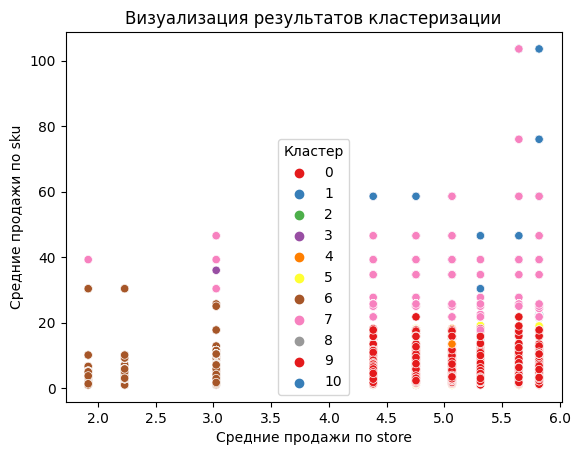

In [319]:
# диаграмма рассеяния для двух признаков
sns.scatterplot(data=clast_activ_store, x='avg_sales_by_store_units', y='avg_sales_by_sku_units', hue='cluster', palette='Set1')

plt.xlabel('Средние продажи по store')
plt.ylabel('Средние продажи по sku')
plt.title('Визуализация результатов кластеризации')

plt.legend(title='Кластер')
plt.show()


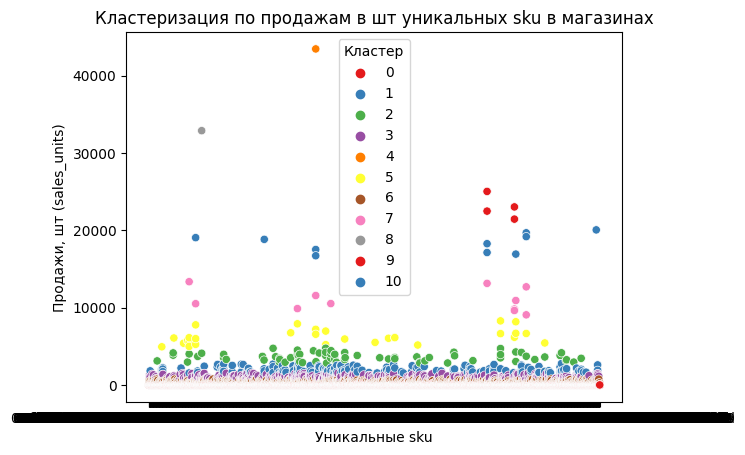

In [321]:
# scatter plot для кластеризации
sns.scatterplot(data=sku_sales_sum, y='sales_units', x='sku', hue='cluster', palette='Set1')

plt.ylabel('Продажи, шт (sales_units)')
plt.xlabel('Уникальные sku')
plt.title('Кластеризация по продажам в шт уникальных sku в магазинах')

plt.legend(title='Кластер')
plt.show()

## Оценим статистики для кластеров

In [323]:
list_clast = np.sort(clast_activ_store['cluster'].unique())
list_clast

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

In [324]:
cluster_stats = {}

for clast in list_clast:
    cluster_data = clast_activ_store[clast_activ_store['cluster'] == clast]['sales_units'].describe().to_frame()
    cluster_stats[clast] = cluster_data

# Создаем DataFrame для всех статистик
combined_stats = pd.concat(cluster_stats, axis=1)

# Добавляем названия кластеров в качестве индекса
combined_stats.index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
combined_stats

,0,1,2,3,4,5,6,7,8,9,10
,sales_units,sales_units,sales_units,sales_units,sales_units,sales_units,sales_units,sales_units,sales_units,sales_units,sales_units
count,87349.000000,123268.000000,90685.000000,2498.000000,13537.000000,66270.000000,31151.000000,9656.000000,430.000000,96539.000000,2112.000000
mean,3.820318,3.547360,3.633876,64.620096,22.369506,3.921020,2.781805,22.077361,169.058140,2.965258,86.282197
std,4.306774,3.655486,3.428353,18.578870,10.908474,3.899221,2.896990,14.698669,114.479053,3.029511,38.248965
min,1.000000,1.000000,1.000000,35.000000,8.000000,1.000000,1.000000,1.000000,102.000000,1.000000,11.000000
25%,1.000000,1.000000,1.000000,50.000000,14.000000,1.000000,1.000000,10.000000,123.000000,1.000000,61.000000
50%,2.000000,2.000000,3.000000,60.000000,19.000000,3.000000,2.000000,20.000000,140.000000,2.000000,77.000000
75%,4.000000,4.000000,4.000000,76.000000,27.000000,5.000000,4.000000,32.000000,167.000000,4.000000,102.250000
max,56.000000,47.000000,36.000000,119.000000,96.000000,42.000000,62.000000,69.000000,1033.000000,48.000000,383.000000


In [327]:
clast_activ_store[(clast_activ_store['store'] == 'c81e728d9d4c2f636f067f89cc14862c') & (clast_activ_store['sku'] == '62d4af457ba2540ce0898a211c0cd17a')].head()

,store,sku,sales_units,sales_rub,group,category,subcategory,uom,division,city,...,avg_sales_by_sku_units,avg_sales_by_year_units,avg_sales_by_weekday_units,avg_sales_by_month_units,avg_sales_by_division_units,avg_sales_by_city_units,avg_sales_by_type_format_units,avg_sales_by_loc_units,avg_sales_by_size_units,cluster
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,89,1294.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,46.555705,5.245576,4.285358,5.474063,5.221882,5.221882,5.234517,4.998441,5.734326,10
2022-08-02,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,77,1118.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,46.555705,5.245576,4.335378,5.474063,5.221882,5.221882,5.234517,4.998441,5.734326,10
2022-08-03,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,70,1022.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,46.555705,5.245576,4.452909,5.474063,5.221882,5.221882,5.234517,4.998441,5.734326,10
2022-08-04,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,71,1031.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,46.555705,5.245576,4.713868,5.474063,5.221882,5.221882,5.234517,4.998441,5.734326,10
2022-08-05,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,86,1255.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,46.555705,5.245576,5.907533,5.474063,5.221882,5.221882,5.234517,4.998441,5.734326,10


In [329]:
clast_activ_store[(clast_activ_store['sku'] == '62d4af457ba2540ce0898a211c0cd17a') & (clast_activ_store['cluster'] == 3)].head()

,store,sku,sales_units,sales_rub,group,category,subcategory,uom,division,city,...,avg_sales_by_sku_units,avg_sales_by_year_units,avg_sales_by_weekday_units,avg_sales_by_month_units,avg_sales_by_division_units,avg_sales_by_city_units,avg_sales_by_type_format_units,avg_sales_by_loc_units,avg_sales_by_size_units,cluster
date,,,,,,,,,,,,,,,,,,,,,
2022-08-06,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,92,1335.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,46.555705,5.245576,6.479903,5.474063,5.221882,5.221882,5.234517,4.998441,5.734326,3
2022-08-06,f7e6c85504ce6e82442c770f7c8606f0,62d4af457ba2540ce0898a211c0cd17a,75,1064.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,32586311f16876abf92901085bd87b99,3202111cf90e7c816a472aaceb72b0df,...,46.555705,5.245576,6.479903,5.474063,5.313372,5.313372,5.234517,4.998441,4.904329,3
2022-08-06,42a0e188f5033bc65bf8d78622277c4e,62d4af457ba2540ce0898a211c0cd17a,49,705.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,46.555705,5.245576,6.479903,5.474063,4.756012,4.756012,5.234517,4.998441,4.904329,3
2022-08-07,f7e6c85504ce6e82442c770f7c8606f0,62d4af457ba2540ce0898a211c0cd17a,69,1008.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,32586311f16876abf92901085bd87b99,3202111cf90e7c816a472aaceb72b0df,...,46.555705,5.245576,5.281107,5.474063,5.313372,5.313372,5.234517,4.998441,4.904329,3
2022-08-07,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,99,1428.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,46.555705,5.245576,5.281107,5.474063,5.221882,5.221882,5.234517,4.998441,5.734326,3


## Сравним продажи выбранного scu в магазине с продажами его кластера

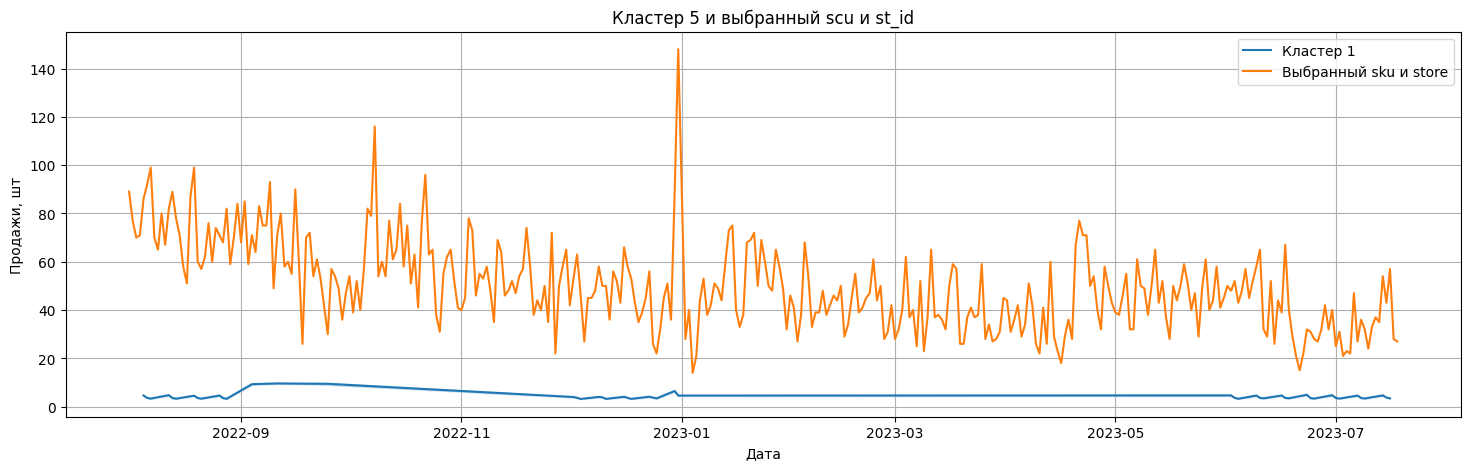

In [330]:
plt.figure(figsize=(18, 5))
# фильтруем данные для выбранного кластера
filtered_data_cl = clast_activ_store[clast_activ_store['cluster'] == 5]
filtered_data_scu = clast_activ_store[(clast_activ_store['sku'] == '62d4af457ba2540ce0898a211c0cd17a') & (clast_activ_store['store'] == 'c81e728d9d4c2f636f067f89cc14862c')]

sns.lineplot(data=filtered_data_cl, x=filtered_data_cl.index, y='sales_units', label='Кластер 1')
sns.lineplot(data=filtered_data_scu, x=filtered_data_scu.index, y='sales_units', label='Выбранный sku и store')

plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title('Кластер 5 и выбранный scu и st_id')
plt.grid(True)

plt.legend()
plt.show()

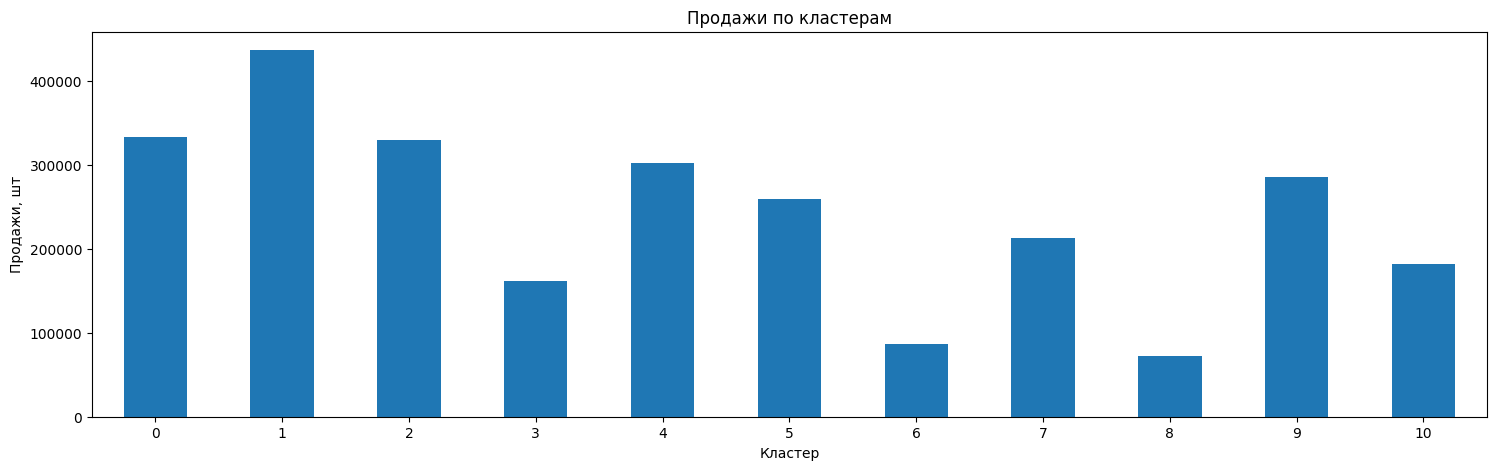

In [331]:
# группируем данные по столбцу 'cluster' и считаем сумму продаж
cluster_sales = clast_activ_store.groupby('cluster')['sales_units'].sum()

# график
plt.figure(figsize=(18, 5))
cluster_sales.plot(kind='bar')
plt.xlabel('Кластер')
plt.ylabel('Продажи, шт')
plt.title('Продажи по кластерам')
plt.xticks(rotation=0)
plt.show()

In [332]:
clast_activ_store

,store,sku,sales_units,sales_rub,group,category,subcategory,uom,division,city,...,avg_sales_by_sku_units,avg_sales_by_year_units,avg_sales_by_weekday_units,avg_sales_by_month_units,avg_sales_by_division_units,avg_sales_by_city_units,avg_sales_by_type_format_units,avg_sales_by_loc_units,avg_sales_by_size_units,cluster
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,21,462.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,429a86ff6336c144ddaf6144f52ab52c,908c9a564a86426585b29f5335b619bc,...,10.441379,5.245576,4.285358,5.474063,5.221882,5.221882,5.234517,4.998441,5.734326,0
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,6,860.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,6.635616,5.245576,4.285358,5.474063,4.756012,4.756012,5.234517,4.998441,4.904329,0
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,3f33017a9ce4fbff701facaeae7a7549,1,65.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,0,296bd0cc6e735f9d7488ebc8fbc19130,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,4.689800,5.245576,4.285358,5.474063,5.275925,5.646487,5.234517,5.646487,5.734326,0
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6d8bf88f6daf3b37de081afcf75ec6cf,17,1012.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,0,296bd0cc6e735f9d7488ebc8fbc19130,885fe656777008c335ac96072a45be15,...,9.964484,5.245576,4.285358,5.474063,5.275925,4.755349,5.234517,4.998441,4.904329,0
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,517b5edeb76505d48bb945abce481959,1,214.0,aab3238922bcc25a6f606eb525ffdc56,186a157b2992e7daed3677ce8e9fe40f,aa36dc1d45661519a5bf923429776a83,1,296bd0cc6e735f9d7488ebc8fbc19130,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,2.826561,5.245576,4.285358,5.474063,5.275925,5.646487,5.234517,5.646487,5.734326,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-18,42a0e188f5033bc65bf8d78622277c4e,1d2448c22721c94bb0264cf52598522f,49,440.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,1507fc0175c1ff0cf4440105bc6f93e6,0,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,25.715023,4.974174,4.335378,5.609771,4.756012,4.756012,5.234517,4.998441,4.904329,7
2023-07-18,16a5cdae362b8d27a1d8f8c7b78b4330,10d26ea8eac593b8e397fc0aad2134c4,2,46.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,6639ae8d530e71980239f7bff60e247c,0,296bd0cc6e735f9d7488ebc8fbc19130,c1f75cc0f7fe269dd0fd9bd5e24f9586,...,3.334395,4.974174,4.335378,5.609771,5.275925,5.646487,5.234517,5.646487,5.734326,0
2023-07-18,42a0e188f5033bc65bf8d78622277c4e,a7a9eb3ffb9634e37c50995c34da34d0,2,83.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,2a307e6985c82c6245bc0b3186cdf9bc,0,da742b3cfca5388aaf9af28a726a3c30,b8b4b727d6f5d1b61fff7be687f7970f,...,3.451702,4.974174,4.335378,5.609771,4.756012,4.756012,5.234517,4.998441,4.904329,0


In [ ]:
#clast_activ_store.columns

In [ ]:
#df = clast_activ_store.copy()

## Классические модели

In [398]:
data2 = prepare_data(merged_df, calendar)

data2

KeyError: ignored

In [ ]:
#CТОП!

In [333]:
classic_activ_store = clast_activ_store.copy()

In [334]:
# топ товаров
['62d4af457ba2540ce0898a211c0cd17a',
 'c0e3f3bd815a862433bc3399c487926b',
 'ced0c1a84924c982a6403870c54b99ca',
 'd5bfeecaaa47887a4b92d17fa55c2e18',
 'cf91eca9321c9c272fb4e7cf4bcc6a43',
 '1d2448c22721c94bb0264cf52598522f',
 '20d9b4bfd4b672f61d87f420856aac5d',
 '1a0f36f6e92560bcae205b6c32cc033f',
 '5aa2f6e00873f8c90b00cd15d670daa1',
 'c7b711619071c92bef604c7ad68380dd']

['62d4af457ba2540ce0898a211c0cd17a',
 'c0e3f3bd815a862433bc3399c487926b',
 'ced0c1a84924c982a6403870c54b99ca',
 'd5bfeecaaa47887a4b92d17fa55c2e18',
 'cf91eca9321c9c272fb4e7cf4bcc6a43',
 '1d2448c22721c94bb0264cf52598522f',
 '20d9b4bfd4b672f61d87f420856aac5d',
 '1a0f36f6e92560bcae205b6c32cc033f',
 '5aa2f6e00873f8c90b00cd15d670daa1',
 'c7b711619071c92bef604c7ad68380dd']

In [335]:
#магазины
['c81e728d9d4c2f636f067f89cc14862c',
 '16a5cdae362b8d27a1d8f8c7b78b4330',
 'f7e6c85504ce6e82442c770f7c8606f0',
 '42a0e188f5033bc65bf8d78622277c4e',
 'fa7cdfad1a5aaf8370ebeda47a1ff1c3',
 '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
 '1ecfb463472ec9115b10c292ef8bc986',
 '53e19f3dbb211f20b20b45668303c1b6',
 'bd470ca955d9497bbcb808e59952fffc']

['c81e728d9d4c2f636f067f89cc14862c',
 '16a5cdae362b8d27a1d8f8c7b78b4330',
 'f7e6c85504ce6e82442c770f7c8606f0',
 '42a0e188f5033bc65bf8d78622277c4e',
 'fa7cdfad1a5aaf8370ebeda47a1ff1c3',
 '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
 '1ecfb463472ec9115b10c292ef8bc986',
 '53e19f3dbb211f20b20b45668303c1b6',
 'bd470ca955d9497bbcb808e59952fffc']

## Модель "CatBoost Regressor" с лучшими гиперпараметрами

# Функция

In [336]:
df = classic_activ_store.copy()

In [343]:
# создадим модель
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE,
                              verbose=False,
                              cat_features=['group', 'category', 'subcategory', 'division',
       'city', 'type_format', 'loc', 'size'])

In [344]:
# лучшие параметры
best_parameters_cbr = [
    {'bagging_temperature': [0.6],
     'depth': [6],
     'iterations': [100],
     #'l2_leaf_reg': [5],
     'learning_rate': [0.1],
     'random_strength': [1.0],
     'verbose': [False]}]

In [356]:
def make_predict_test(df, store, sku):
    sku_st = df[(df['store'] == store) & (df['sku'] == sku)]

    # дата начала тестовой выборки (последние 14 дней)
    test_end_date = sku_st.index.max()

    # делим на трейн и тест
    train_df = sku_st[sku_st.index < test_end_date - pd.DateOffset(days=14)]
    test_df = sku_st[(sku_st.index >= test_end_date - pd.DateOffset(days=14)) & (sku_st.index <= test_end_date)]

    # признаки (X) и целевая переменная (y)
    X_train = train_df.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand', 'store', 'sku'], axis=1)
    y_train = train_df['sales_units_stand']

    X_test = test_df.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand', 'store', 'sku'], axis=1)
    y_test = test_df['sales_units_stand']
    splits = TimeSeriesSplit(n_splits=(len(X_train) // 14))

    # модель
    grid_cbr = GridSearchCV(estimator=model_cbr, param_grid = best_parameters_cbr, cv=splits,
                            verbose=True, scoring='neg_root_mean_squared_error', n_jobs=-1)

    grid_cbr.fit(X_train, y_train)
    best_model_cbr = grid_cbr.best_estimator_

    predict_test_cbr = best_model_cbr.predict(X_test)

    predicted_df = pd.DataFrame({'prediction': predict_test_cbr}, index=y_test.index)
    predicted_df.reset_index(inplace=True)

    test_df = test_df.copy()
    test_df.reset_index(inplace=True)

    result_df = predicted_df.merge(test_df[['date', 'sales_units_stand']], on='date', how='inner')\
                                          [['date', 'prediction', 'sales_units_stand']]
    result_df[['prediction','sales_units']] = (result_df[['prediction', 'sales_units_stand']] \
                         .apply(lambda x: (x * sales_units_sd) + sales_units_mean)).round()
    result_df['wape'] = result_df.apply(lambda row: np.sum(np.abs(row['sales_units'] - row['prediction']))\
                                        / np.sum(np.abs(row['sales_units'])), axis=1)
    average_wape = result_df['wape'].mean()
    print(f"Среднее значение WAPE: {average_wape}")

    result_df = result_df.drop(['sales_units_stand'] , axis=1)
    pred_df = result_df[['date', 'sales_units', 'prediction', 'wape' ]]

    pred_sales_submission = pd.merge(pred_df, test_df, on=['date', 'sales_units'], how='left')
    pred_sales_submission = pred_sales_submission[['store', 'sku', 'date', 'prediction', 'sales_units', 'wape']]
    pred_sales_submission

    return pred_sales_submission

In [362]:
# создаем словарь, где ключ - это магазин, а значения - это все товары, которые имеются в магазине
store_dict = df.groupby('store')['sku'].apply(list).to_dict()

# собираем в список все магазины
st_ids = list(store_dict.keys())

# если для каких-то определенных собираем в список:
stores = ['c81e728d9d4c2f636f067f89cc14862c']
skus = ['62d4af457ba2540ce0898a211c0cd17a',
              'c0e3f3bd815a862433bc3399c487926b']

In [409]:
# Создаем пустой датафрейм для хранения всех результатов
result_df = pd.DataFrame()

# считаем прогнозы для нужных магазинов и товаров
for st in stores:
    for sku in skus:
        try:
            df_1 = make_predict_test(data2, st, sku)
            result_df = pd.concat([result_df, df_1], ignore_index=True)
        except Exception as e:
            print(f"Ошибка при обработке st_id:{st}, pr_sku_id:{sku}: {e}")

display(result_df)

Fitting 23 folds for each of 1 candidates, totalling 23 fits
Среднее значение WAPE: 0.184911392803742
Fitting 23 folds for each of 1 candidates, totalling 23 fits
Среднее значение WAPE: 0.1771948810095484


,store,sku,date,prediction,sales_units,wape
0,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-04,28.0,23.0,0.217391
1,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-05,36.0,22.0,0.636364
2,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-06,27.0,47.0,0.425532
3,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-07,32.0,27.0,0.185185
4,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-08,35.0,36.0,0.027778
5,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-09,27.0,32.0,0.156250
6,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-10,27.0,24.0,0.125000
7,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-11,26.0,33.0,0.212121
8,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-12,27.0,37.0,0.270270
9,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,2023-07-13,27.0,35.0,0.228571


In [364]:
print(f"Среднее значение WAPE: {result_df.wape.mean()}")

Среднее значение WAPE: 0.18746450457344493


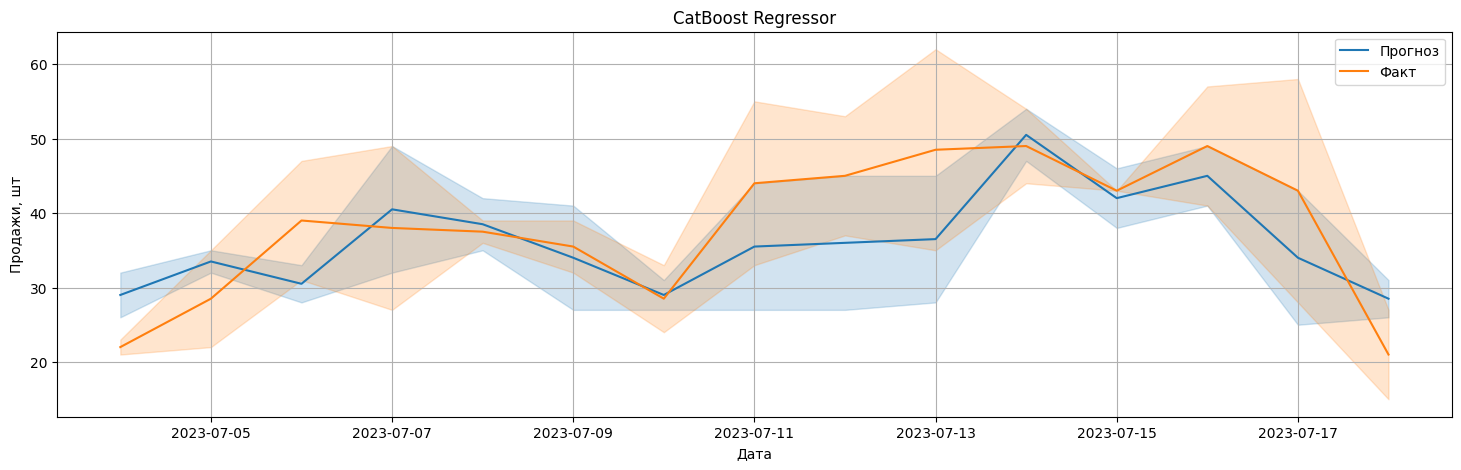

In [360]:
plt.figure(figsize=(18, 5))
# фильтруем данные для выбранного кластера
filtered_data_pred = result_df[(result_df['sku'] == 'd5bfeecaaa47887a4b92d17fa55c2e18') & (result_df['store'] == 'c81e728d9d4c2f636f067f89cc14862c')]
filtered_data_fact = result_df[(result_df['sku'] == 'd5bfeecaaa47887a4b92d17fa55c2e18') & (result_df['store'] == 'c81e728d9d4c2f636f067f89cc14862c')]

sns.lineplot(data=result_df, x='date', y='prediction', label='Прогноз')
sns.lineplot(data=result_df, x='date', y='sales_units', label='Факт')

plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title('CatBoost Regressor')
plt.grid(True)

plt.legend()
plt.show()

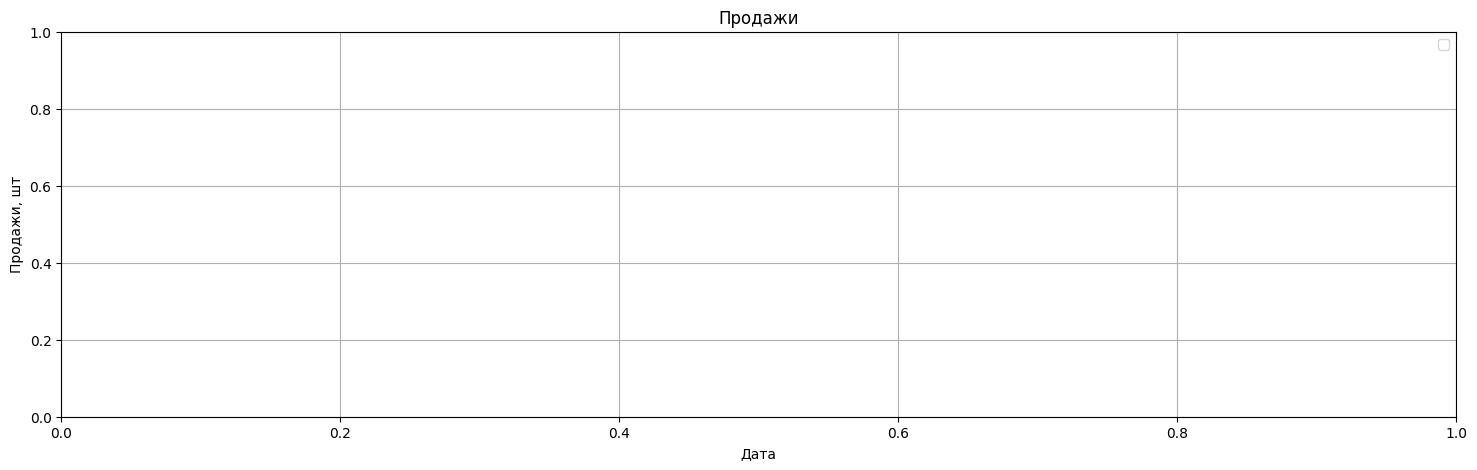

In [361]:
plt.figure(figsize=(18, 5))

filtered_data_scu = clast_activ_store[(clast_activ_store['sku'] == 'c0e3f3bd815a862433bc3399c487926b') & (clast_activ_store['store'] == 'f7e6c85504ce6e82442c770f7c8606f0')]


sns.lineplot(data=filtered_data_scu, x=filtered_data_scu.index, y='sales_units', label='Выбранный sku и store')

plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title('Продажи')
plt.grid(True)

plt.legend()
plt.show()

In [ ]:
filtered_data_scu

,st_id,pr_sku_id,pr_sales_in_units,pr_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_division_code,st_city_id,...,avg_sales_by_month,avg_sales_by_pr_cat_id,avg_sales_by_pr_subcat_id,avg_sales_by_st_division_code,avg_sales_by_st_city_id,avg_sales_by_st_type_format_id,avg_sales_by_st_type_loc_id,avg_sales_by_st_type_size_id,avg_sales_in_holiday,cluster
date,,,,,,,,,,,,,,,,,,,,,
